# Genomics I: Assignment \#1

In [658]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
import collections

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"

## Part I

In [2]:
results = []
params = []

with open("grid_search.txt", 'r') as file:
    for line in file.readlines():
        if line[0]=='F':
            results.append([int(x) for x in re.split(' |,|/', line) if x.isdigit()])
        elif line[0]=='k':
            params.append([int(x) for x in re.split(' |=|\n', line) if x.isdigit()]) 
            
merged = np.array([a+results[idx] for idx, a in enumerate(params)])

In [85]:
grid = pd.DataFrame(merged, columns = ["kmer", 
                                       "cov_cutoff", 
                                       "exp_cov", 
                                       "n_nodes", 
                                       "n50", 
                                       "max", 
                                       "total", 
                                       "reads_used", 
                                       "reads_total"])
grid["percent_reads_used"] = grid["reads_used"]/grid["reads_total"]*100

In [237]:
kmers = [17, 19, 21, 23]
values = ["n50", "total", "percent_reads_used"]
value_names = ["N50", "Total length", "Reads used (%)"]
fmt = ["d", "d", ".1f"]

def plot_grid(kmers, values, value_names, value_formats, saveas=None):
    
    fig, ax = plt.subplots(len(kmers),len(values), figsize = (3.3*len(values), 2.4*len(kmers)))
    name_dict = dict(zip(values, value_names))
    
    for i,k in enumerate(kmers):
        for j,v in enumerate(values):
            sns.heatmap(grid[grid['kmer']==k].pivot('exp_cov', 'cov_cutoff', v),
                    annot=True,
                    fmt = fmt[j],
                    annot_kws = {"fontsize":5},
                    cbar = False,
                    square = True,
                    ax = ax[i, j])
            ax[i,j].invert_yaxis()       

            # formatting
            if j==0:
                ax[i,j].set_title(f"{k}-mer")

            else:
                ax[i,j].set_ylabel("")
                ax[i,j].set_yticks([])

            if i==0:
                ax[i,j].set_title(name_dict[v])
                ax[i,j].set_xlabel("")
                ax[i,j].set_xticks([])
            elif i==len(kmers)-1:
                ax[i,j].set_xlabel("cov_cutoff")
            else:
                ax[i,j].set_xlabel("")
                ax[i,j].set_xticks([])

    ax[0,0].set_title(f"{kmers[0]}-mer | {value_names[0]}");
    fig.subplots_adjust(hspace = 0.2, wspace = 0.1)
    if saveas:
        fig.savefig(fname=saveas)


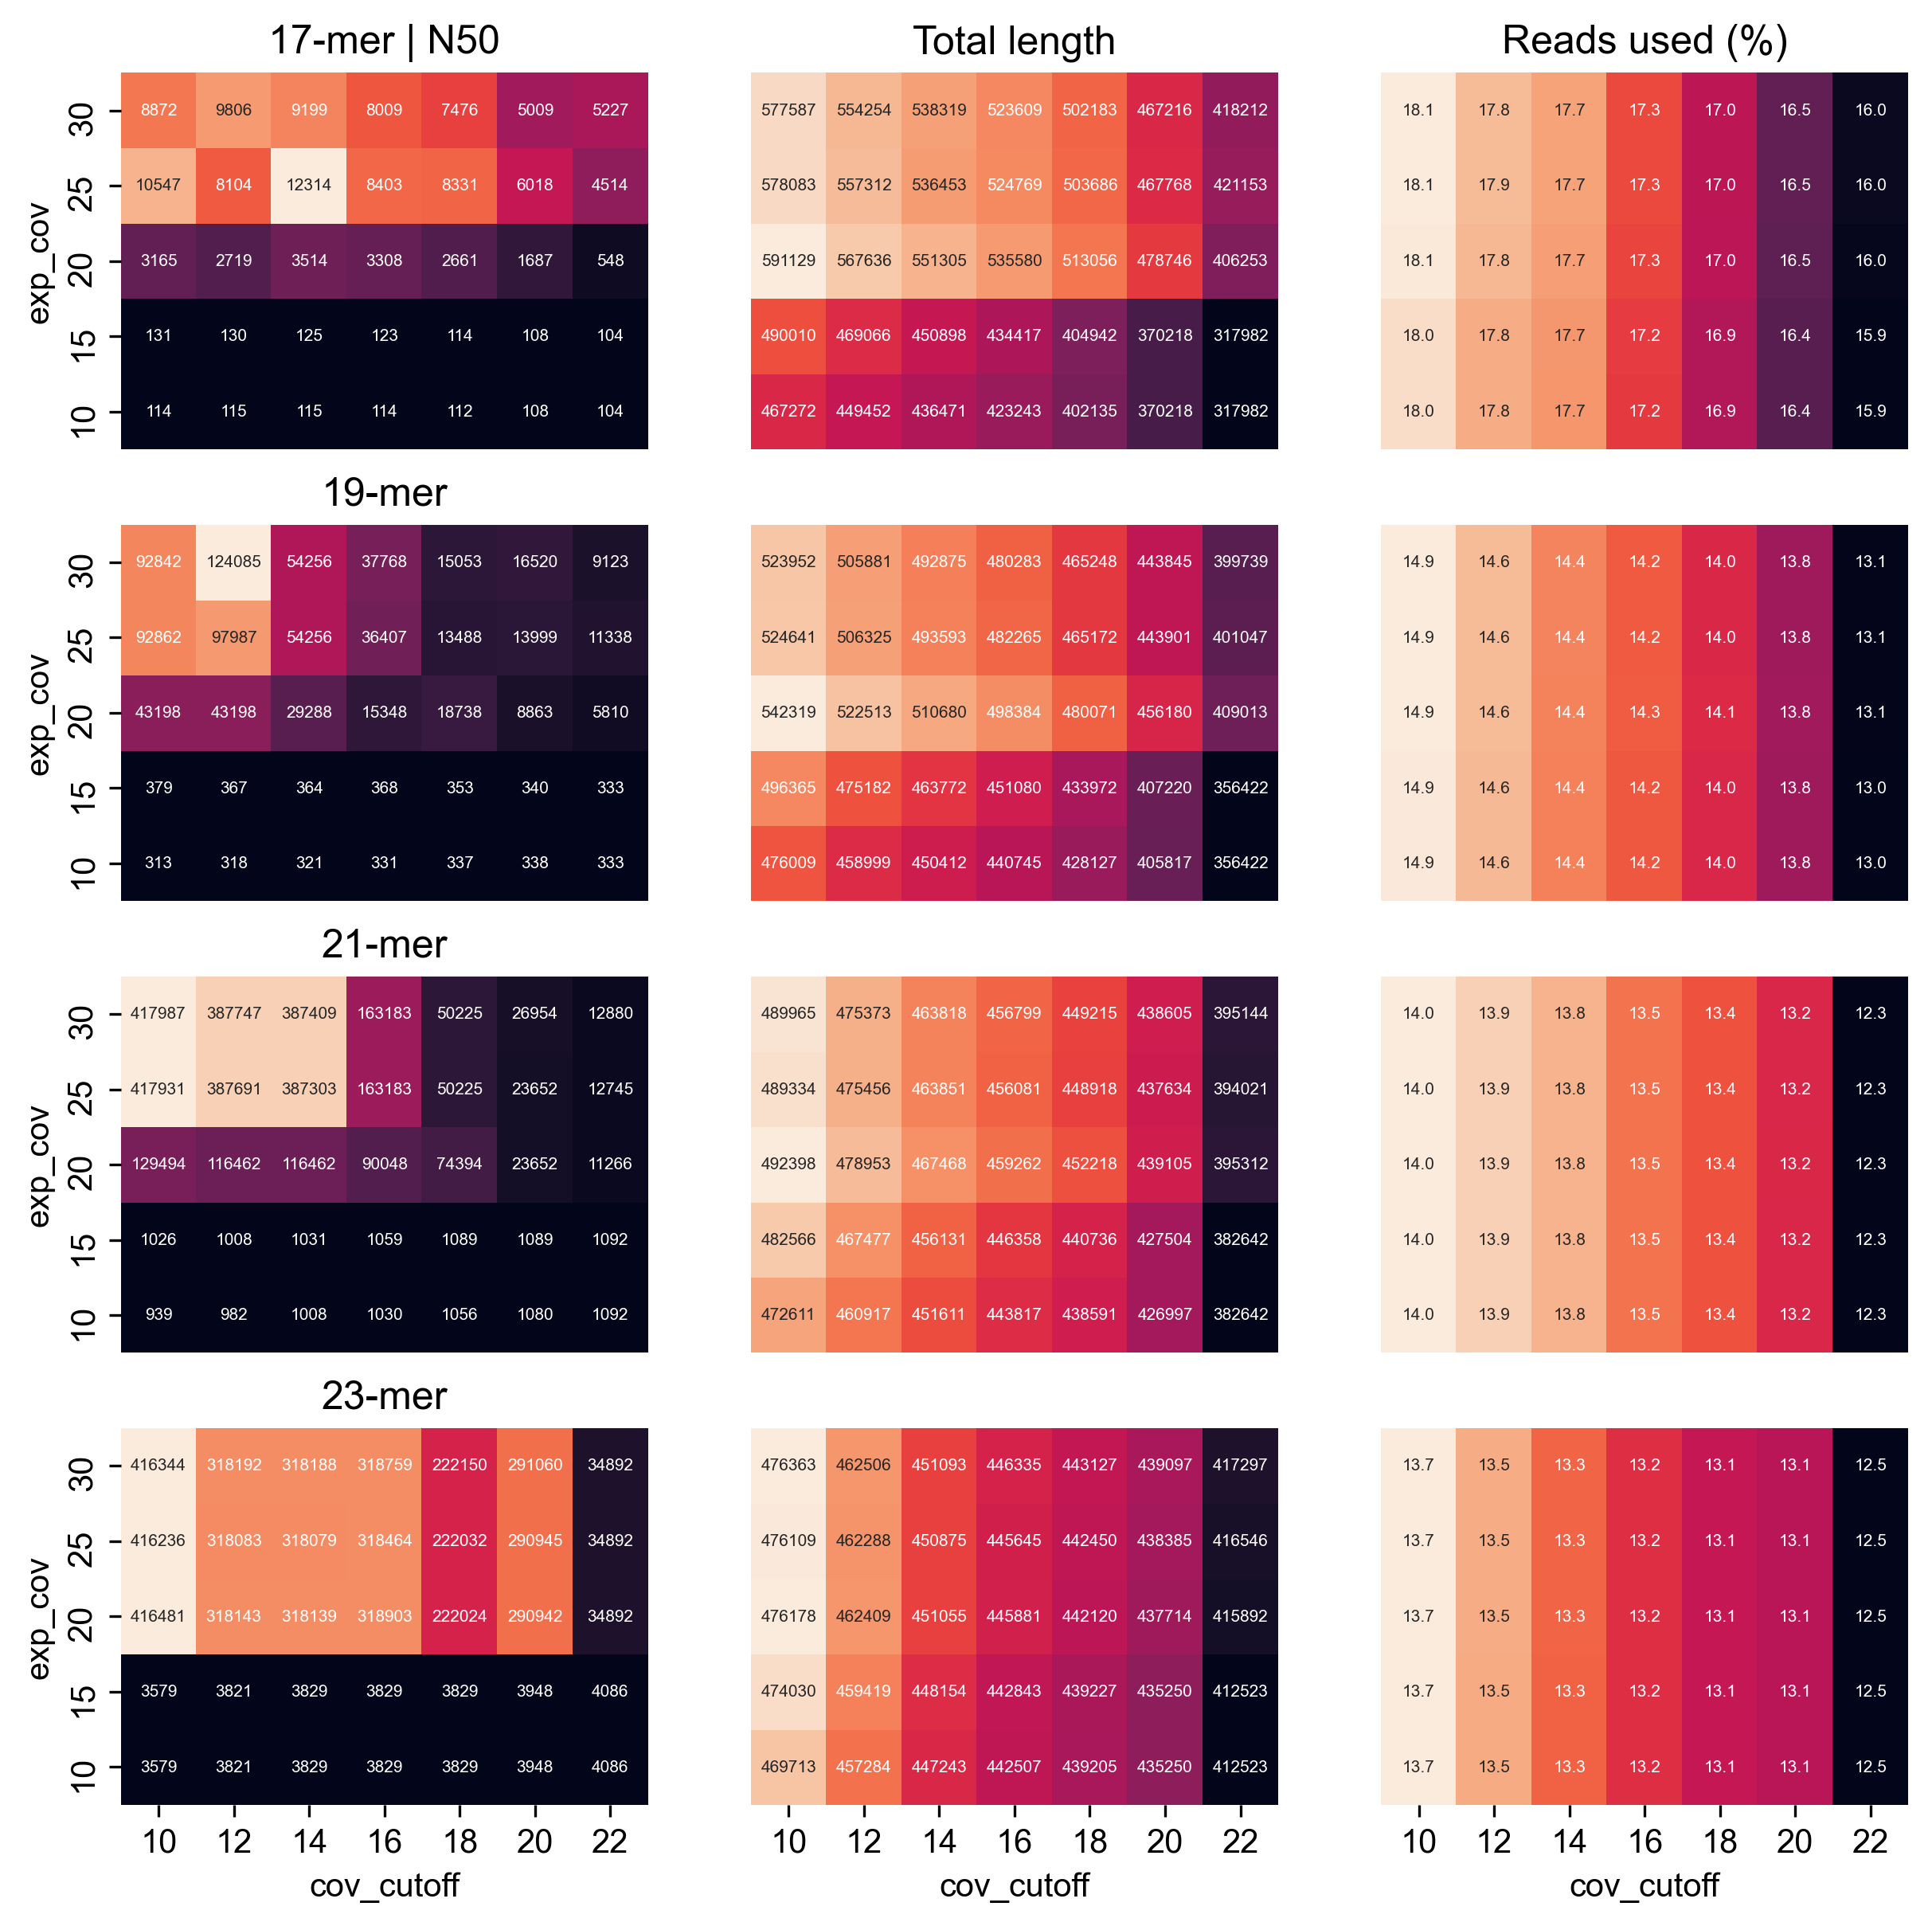

In [241]:
plot_grid(kmers = [17, 19, 21, 23], 
          values = ["n50", "total", "percent_reads_used"], 
          value_names = ["N50", "Total length", "Reads used (%)"], 
          value_formats = ["d", "d", ".1f"],
          saveas = "k17to23.png")

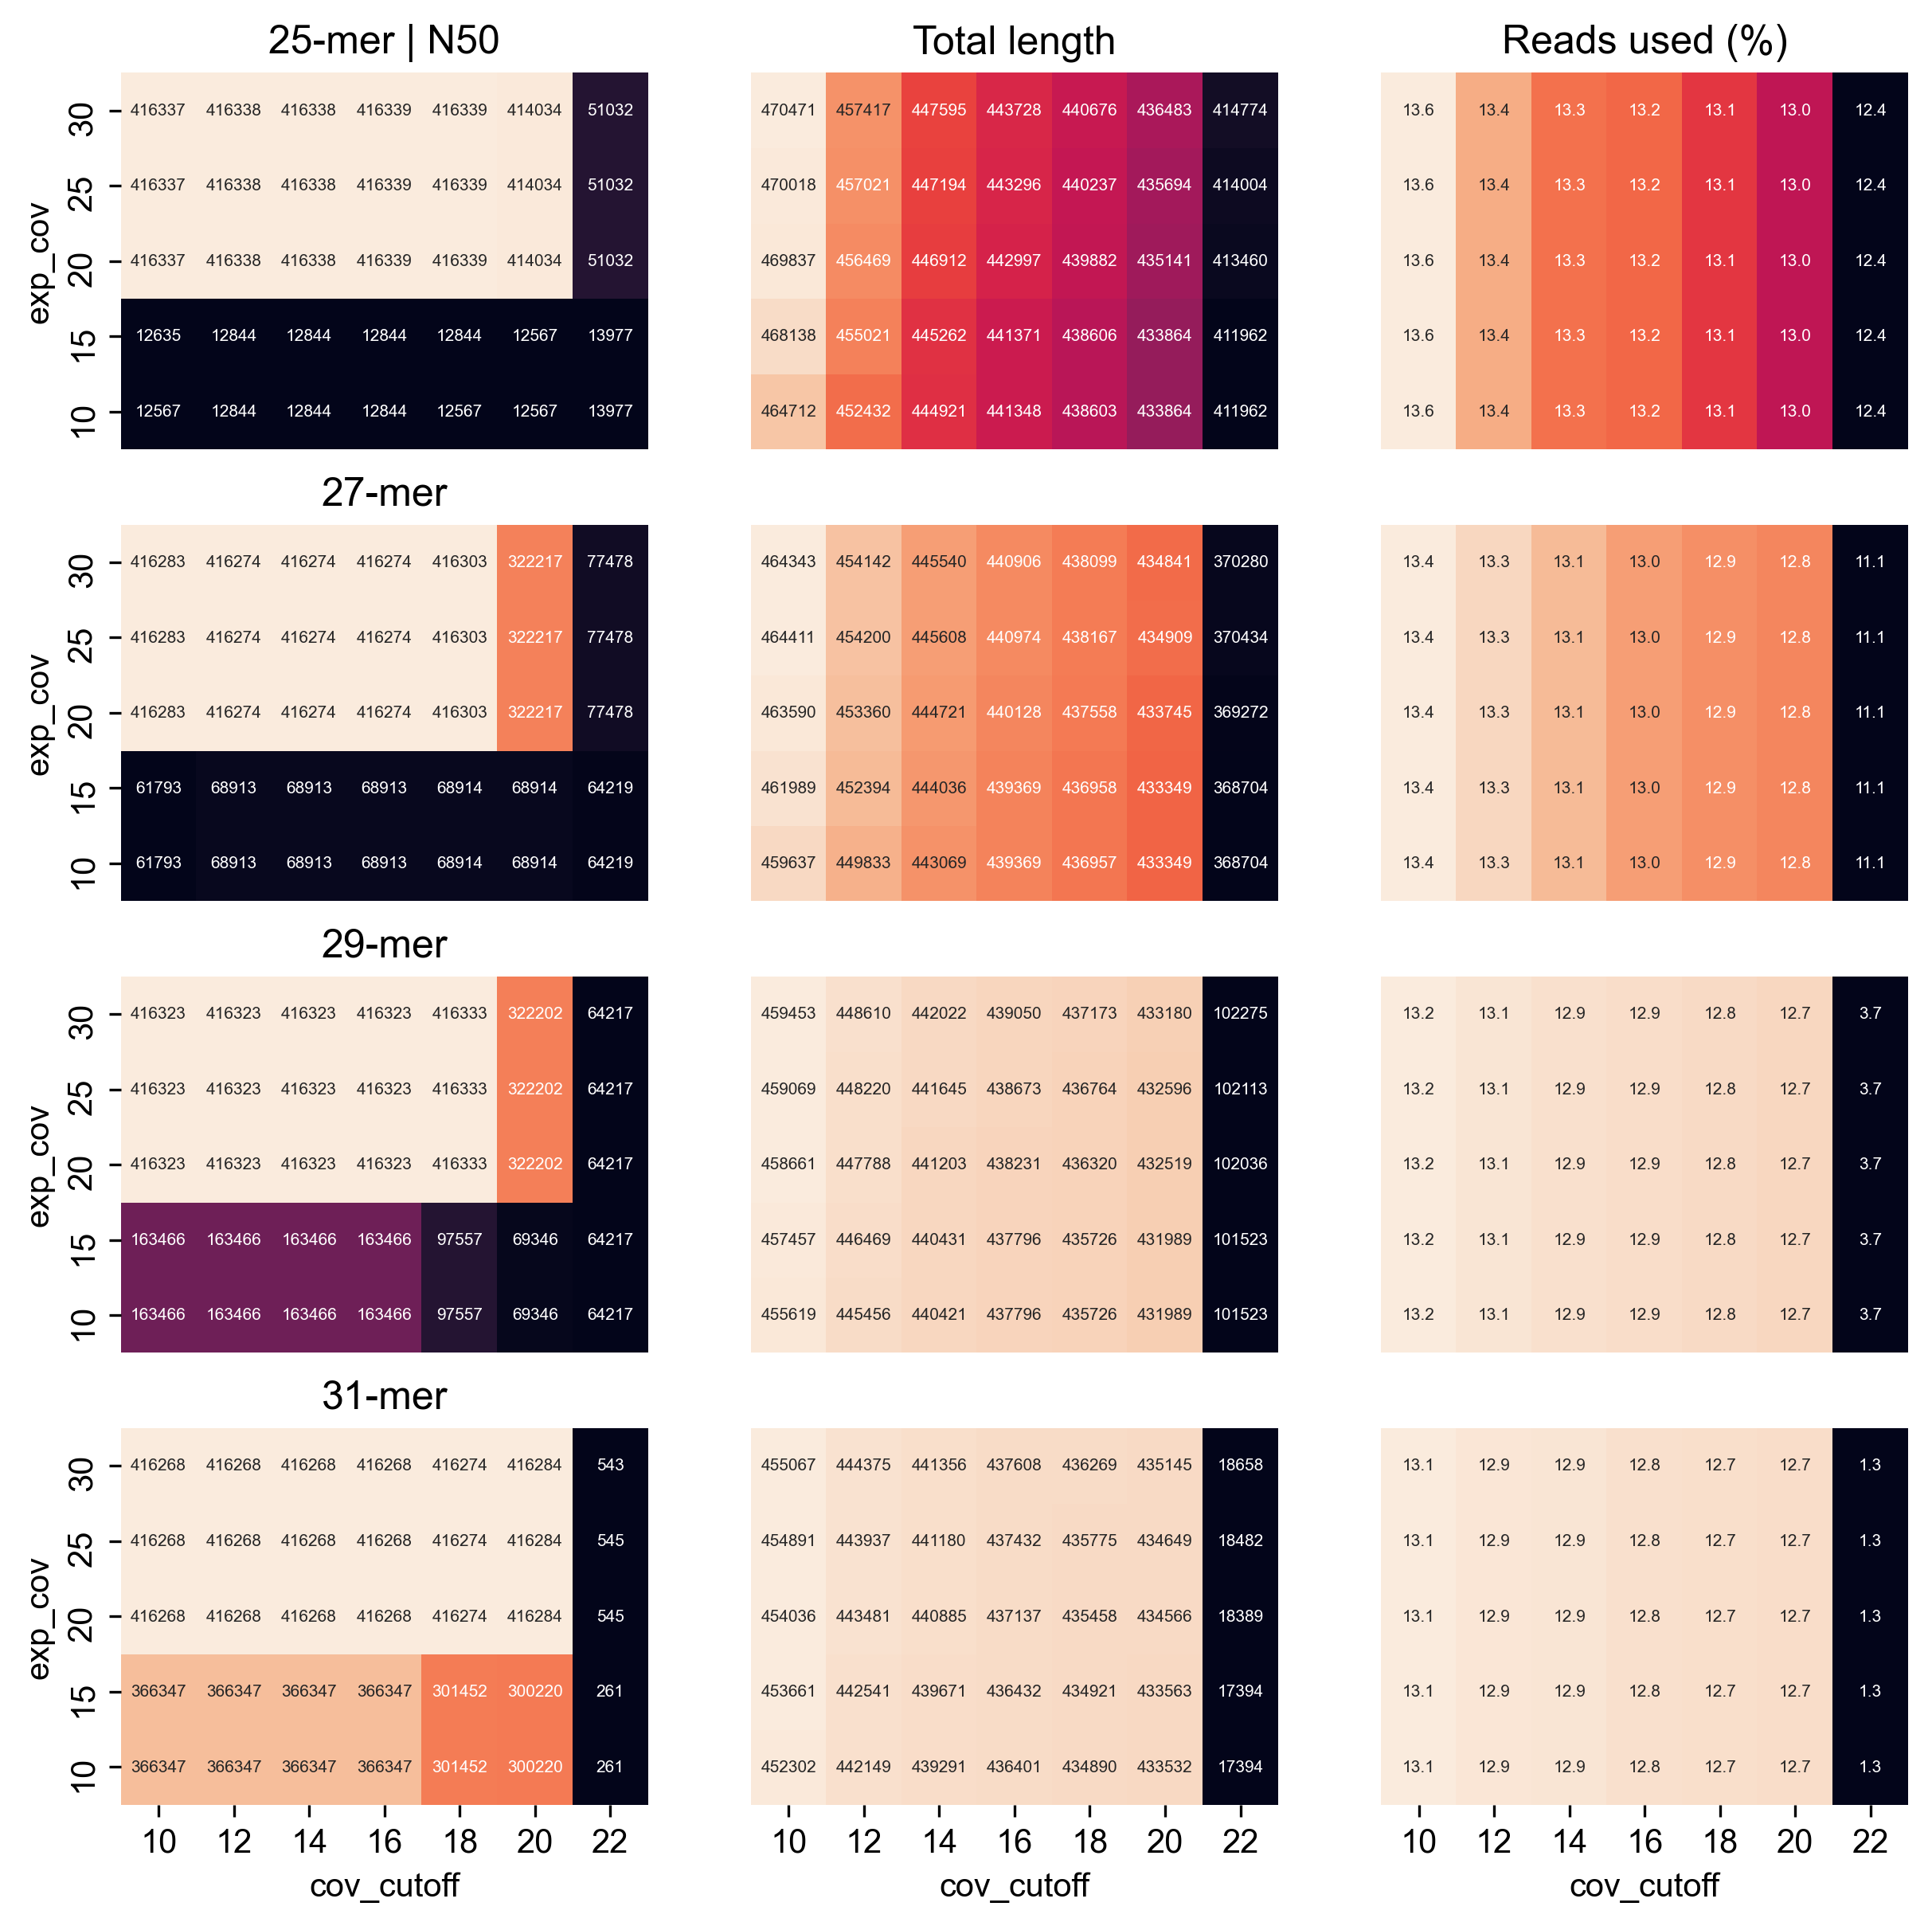

In [242]:
plot_grid(kmers = [25, 27, 29, 31], 
          values = ["n50", "total", "percent_reads_used"], 
          value_names = ["N50", "Total length", "Reads used (%)"], 
          value_formats = ["d", "d", ".1f"],
          saveas = "k25to31.png")

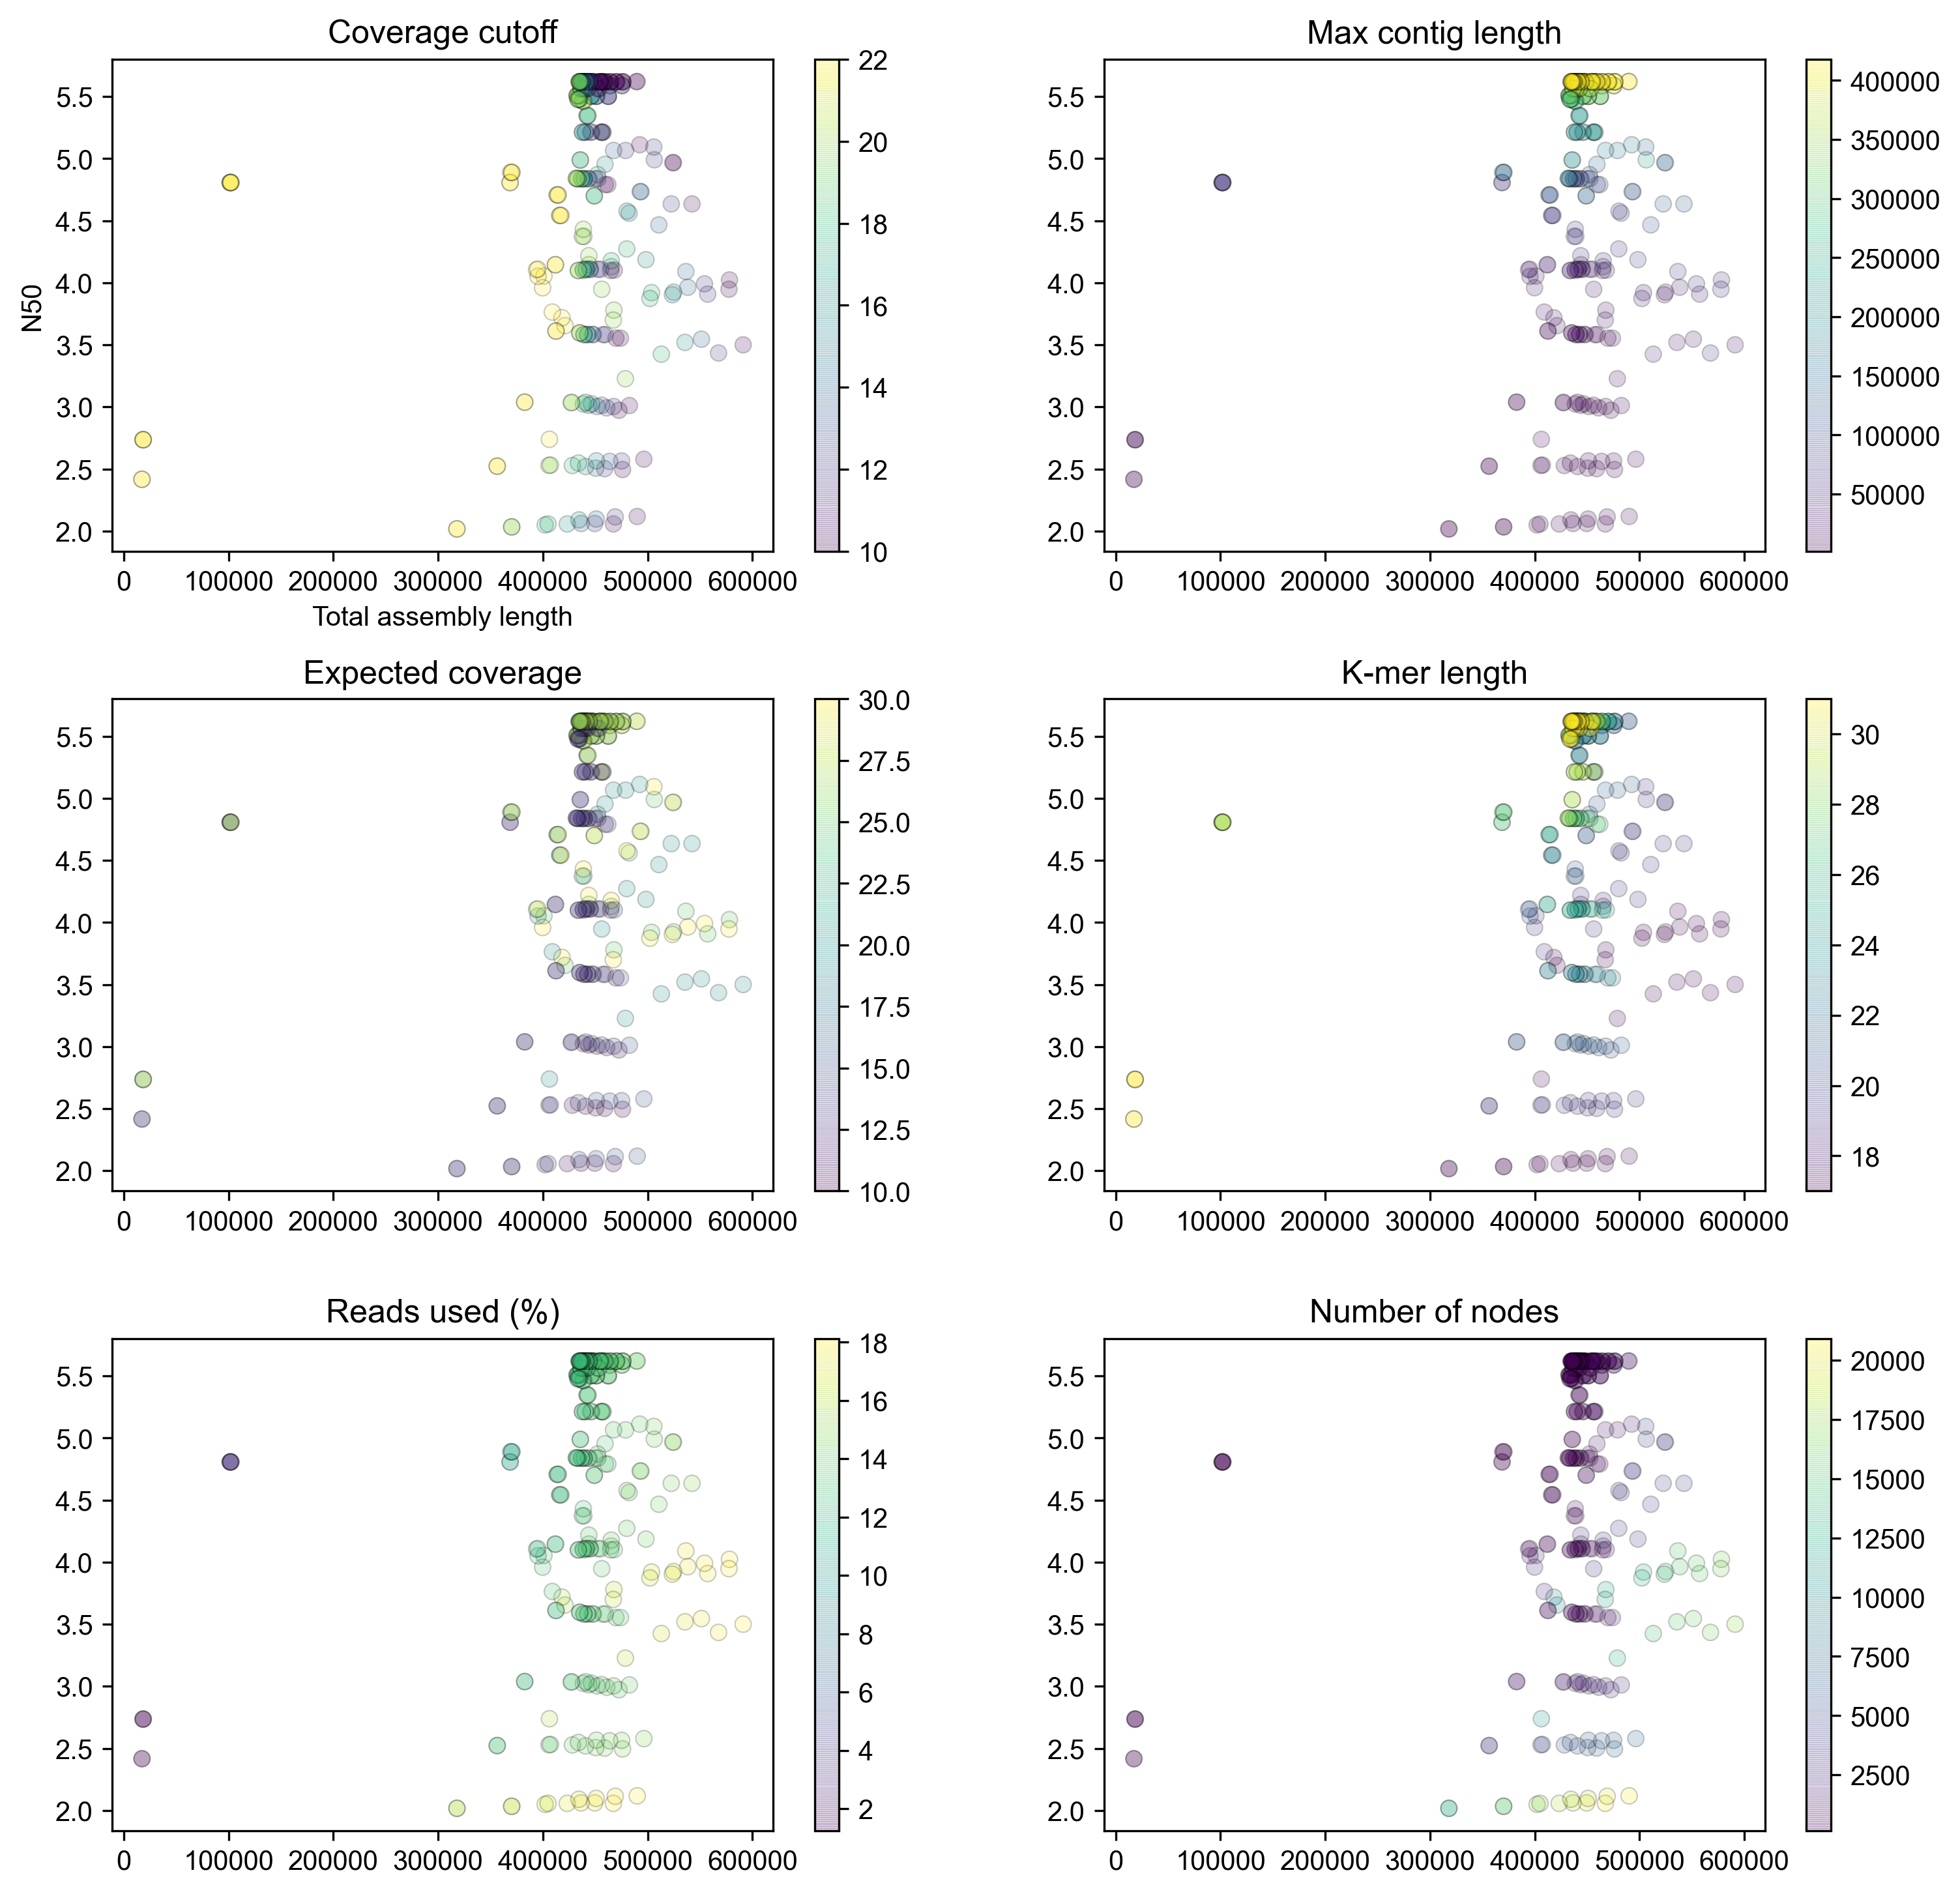

In [231]:
fig, ax = plt.subplots(3,2, figsize = (12,12))

color_values = ["cov_cutoff", "exp_cov", "percent_reads_used", "max", "kmer", "n_nodes"]
color_value_names = ["Coverage cutoff", "Expected coverage", "Reads used (%)", "Max contig length", "K-mer length", "Number of nodes"]
m,n = np.meshgrid([0,1,2], [0,1])

for idx,v in enumerate(color_values):
    ax_ = ax[m.flatten()[idx],n.flatten()[idx]]
    sc = ax_.scatter(grid['total'], 
                     np.log10(grid['n50']), 
                     alpha = 0.2, 
                     c = grid[v], 
                     edgecolor = "black", 
                     linewidth = 0.5)
    fig.colorbar(sc, ax=ax_)
    ax_.set_title(color_value_names[idx])

ax[0,0].set_xlabel("Total assembly length")
ax[0,0].set_ylabel("N50")
fig.subplots_adjust(hspace = 0.3)

fig.savefig("n50_v_total_complete.png")


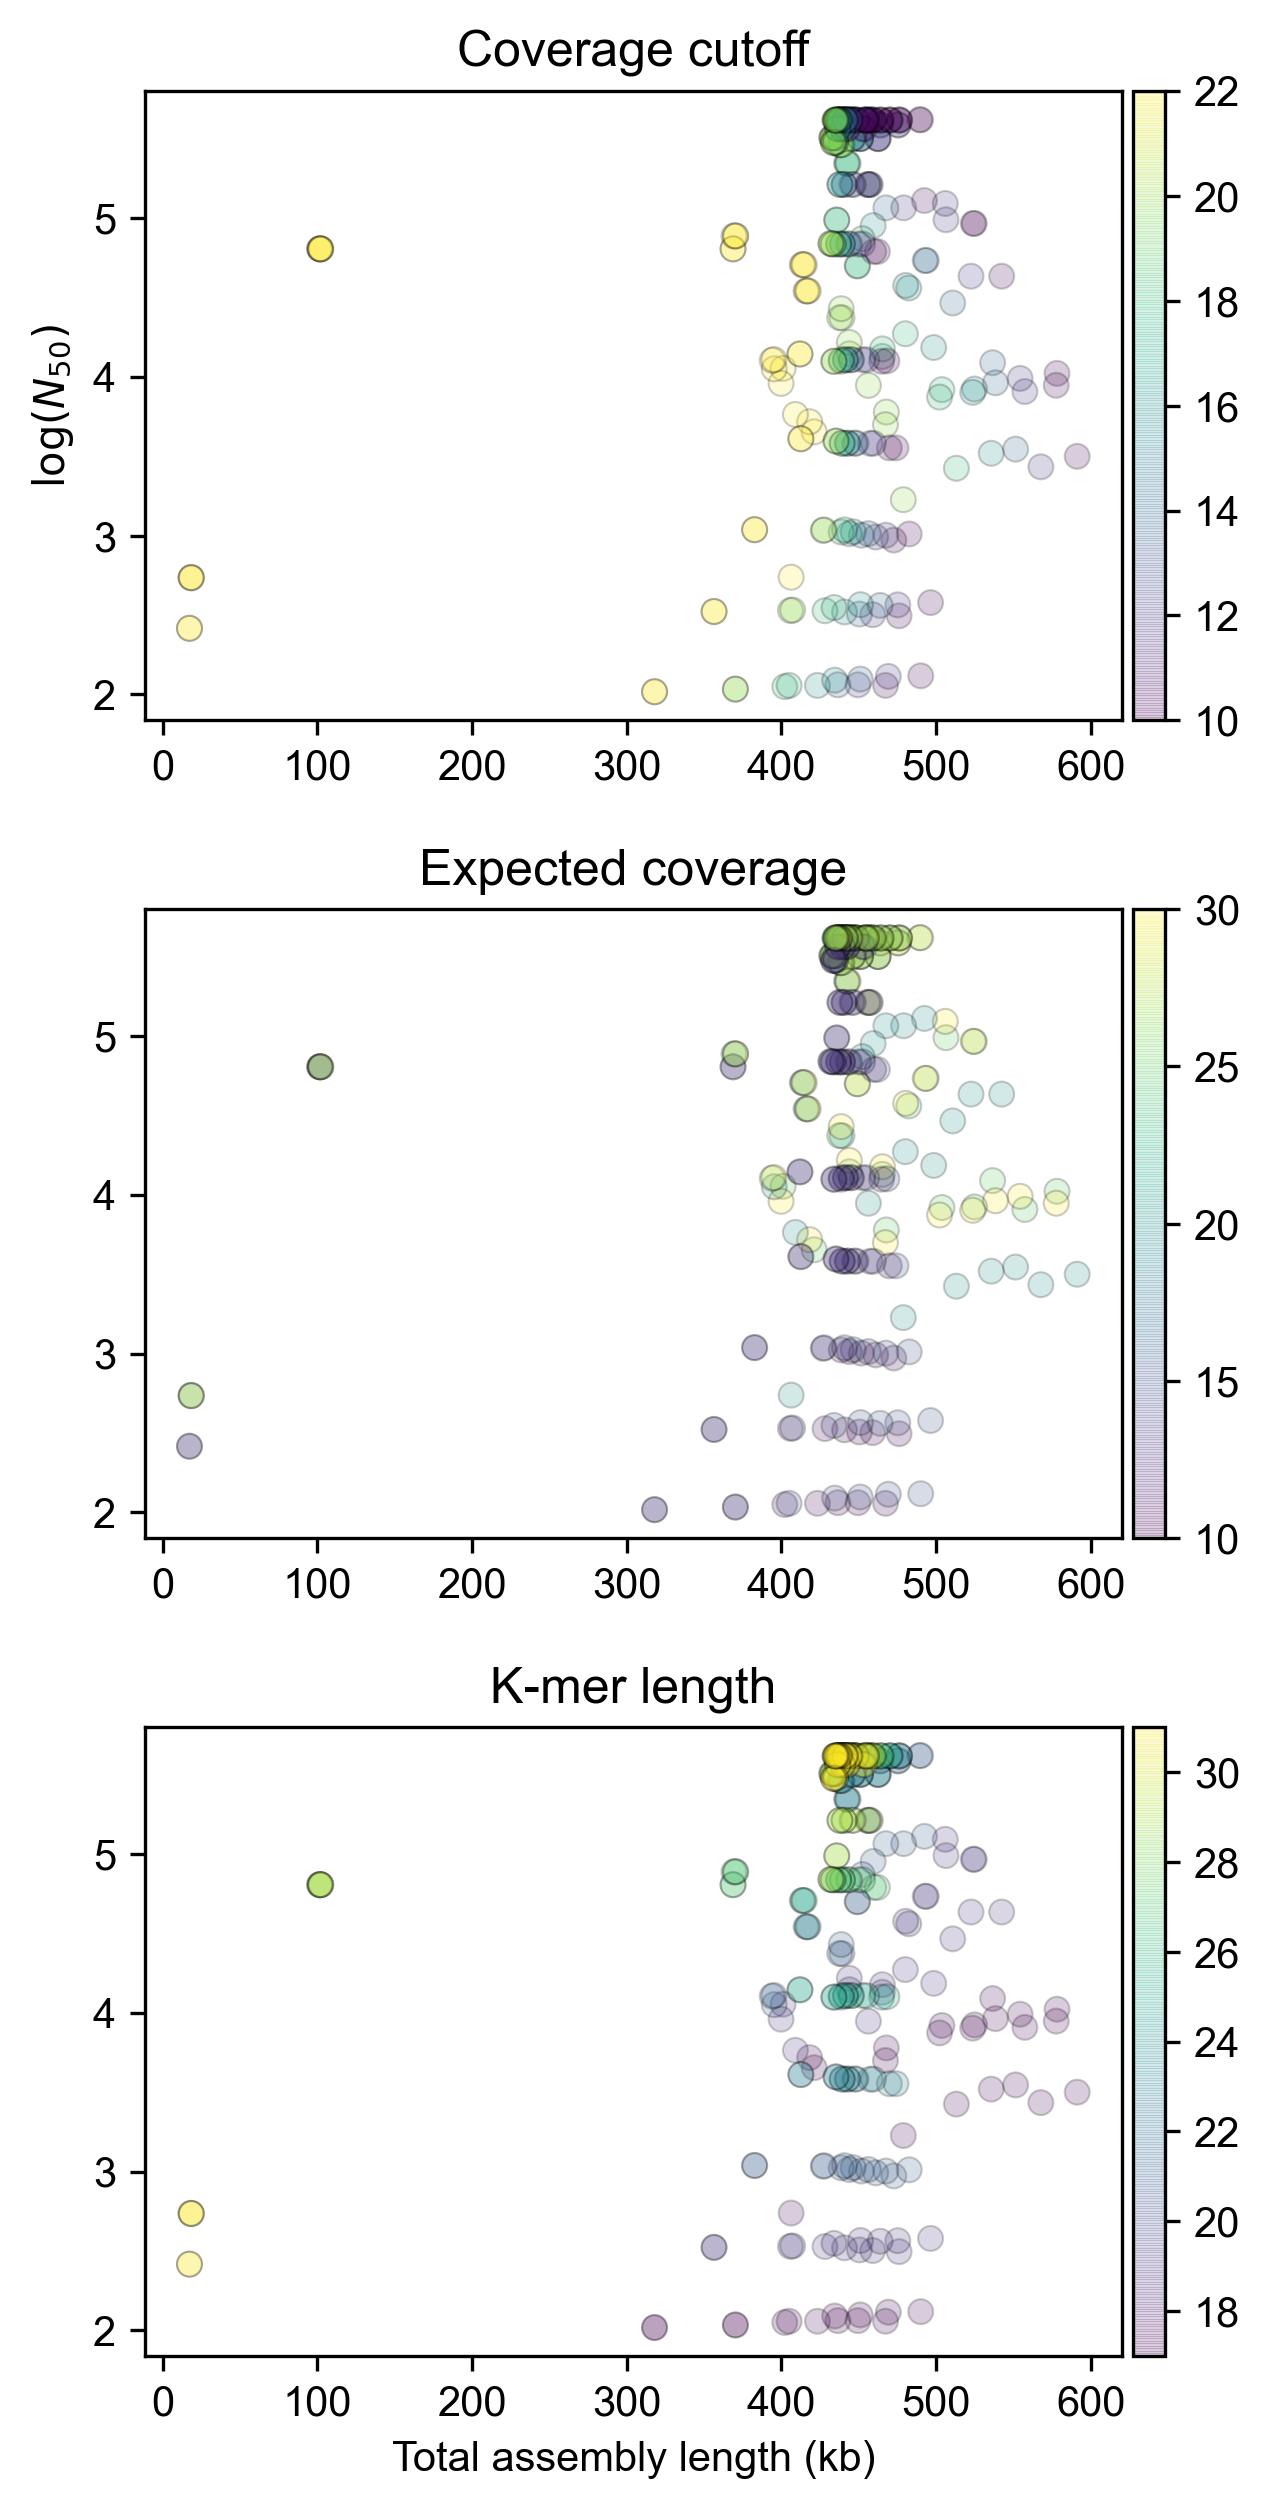

In [232]:
fig, ax = plt.subplots(3,1, figsize = (5,10))

color_values = ["cov_cutoff", "exp_cov", "kmer"]
color_value_names = ["Coverage cutoff", "Expected coverage", "K-mer length"]

for idx,v in enumerate(color_values):
    ax_ = ax[idx]
    sc = ax_.scatter(grid['total']/1000, 
                     np.log10(grid['n50']), 
                     alpha = 0.2, 
                     c = grid[v], 
                     edgecolor = "black", 
                     linewidth = 0.5)
    fig.colorbar(sc, ax=ax_, pad = 0.01)
    ax_.set_title(color_value_names[idx])

ax[2].set_xlabel("Total assembly length (kb)")
ax[0].set_ylabel(r"$\log(N_{50})$")
fig.subplots_adjust(hspace = 0.3)

fig.savefig("n50_v_total_partial.png")

## Part II

In [460]:
def fasta_extract_gene_info(fname, compiled_regex, columns, types):
    info = []
    line_counter = 0
    with open(fname, "r") as file:
        for line in file.readlines():
            if line[0]==">":
                line_counter += 1
                if compiled_regex.findall(line):
                    info += compiled_regex.findall(line)
                else:
                    print(line)
                
    df = pd.DataFrame(info, columns = columns)
    print(f"# of relevant lines seen: {line_counter}")
                
    return df.astype(types)    

In [461]:
# parsing through the fasta files
ecoli = fasta_extract_gene_info("ecoli_genes.fa", 
                                compiled_regex = re.compile(r'>(\S*).*Chromosome:(\d+):(\d+):(\-?)\d+.*transcript:(\S*)(?: description:"(.*)")?\n?'), 
                                columns = ["fa_name", "chr_start", "chr_end", "chr_str", "transcript", "description"],
                                types = {"chr_start": "int32", "chr_end": "int32"})
baphidicola = fasta_extract_gene_info("Buchnera_aphidicola_bcc_gca_000090965.ASM9096v1.cdna.all.fa", 
                                compiled_regex = re.compile(r'>(\S*).*(?:Chromosome|pLeu-BCc):(\d+):(\d+):(\-?)\d+ gene:(\S*) gene_biotype:(\S*) transcript_biotype:(\S*) gene_symbol:(\S*)(?: description:(.*)\n)?'), 
                                columns = ["fa_name","chr_start", "chr_end", "chr_str", "gene", "gene_biotype", "transcript_biotype", "gene_symbol", "description"],
                                types = {"chr_start": "int32", "chr_end": "int32"})

# making the strand directions numerical
baphidicola["chr_str"] = baphidicola["chr_str"].replace("-", -1).replace("", +1)
ecoli["chr_str"] = ecoli["chr_str"].replace("-", -1).replace("", +1)

# calculating the length of each gene
baphidicola["length"] = baphidicola["chr_end"] - baphidicola["chr_start"] + 1
ecoli["length"] = ecoli["chr_end"] - ecoli["chr_start"] + 1

# of relevant lines seen: 3635
# of relevant lines seen: 365


In [1220]:
# reading the sequences
def fasta_read_seqs(fname):
    seqs = []
    seq = ""
    with open(fname, "r") as file:
        for line in file.readlines():
            if line[0]==">":
                seqs.append(seq)
                seq = ""
            else:
                seq += line.strip()
        seqs.append(seq)
    return seqs[1:]

ecoli_seqs = fasta_read_seqs("ecoli_genes.fa")
baphi_seqs = fasta_read_seqs("Buchnera_aphidicola_bcc_gca_000090965.ASM9096v1.cdna.all.fa")
ecoli_atdensity = [(s.count("A")+s.count("T"))/len(s) for s in ecoli_seqs]
baphi_atdensity = [(s.count("A")+s.count("T"))/len(s) for s in baphi_seqs]
baphidicola["at_density"] = baphi_atdensity
ecoli["at_density"] = ecoli_atdensity

In [1291]:
sum([len(x) for x in baphi_seqs])/len(baphi_seqs)

995.1835616438356

In [1225]:
def read_alignment_file(fname, compiled_regex, columns, types):
    with open(fname, "r") as file:
        alignments = []
        line_counter = 0
        for line in file.readlines():
            if line[0:6]=="vulgar":
                line_counter += 1
                if compiled_regex.findall(line):
                    alignments += compiled_regex.findall(line)
                else:
                    print(line)
                    
    print(f"# of relevant lines seen: {line_counter}")
    df = pd.DataFrame(alignments, columns = columns)
    
    return df.astype(types)

In [1226]:
local = read_alignment_file("local.txt", 
                       compiled_regex = re.compile(r'vulgar: (\S*) (\d+) (\d+) \+ (\S*) (\d+) (\d+) (\-|\+) (\d+)'),
                       columns = ["Ba_gene", "Ba_start", "Ba_end", "Ec_gene", "Ec_start", "Ec_end", "strand", "raw_score"],
                       types = { "Ba_start":"int32", "Ba_end":"int32", "Ec_start":"int32", "Ec_end":"int32", "raw_score":"int32"})

local["strand"] = local["strand"].replace("-", -1).replace("+", 1)

# joining the tables to make analysis easier
local_ = pd.merge(left = local, right = baphidicola.add_suffix("_ba"), how = "left", left_on = "Ba_gene", right_on = "fa_name_ba")
local_ = pd.merge(left = local_, right = ecoli.add_suffix("_ec"), how = "left", left_on = "Ec_gene", right_on = "fa_name_ec")

# of relevant lines seen: 3654


In [1227]:
# finding cover in base pairs
local_["ec_align_length"] = np.abs(local_["Ec_end"] - local_["Ec_start"])
local_["ba_align_length"] = np.abs(local_["Ba_end"] - local_["Ba_start"])

In [1228]:
# find min cover in base pairs
local_["min_cover_bp"] = local_[['ec_align_length','ba_align_length']].min(axis=1)

# finding cover in percentage
local_["ec_align_length_percent"] = local_["ec_align_length"] / local_["length_ec"]
local_["ba_align_length_percent"] = local_["ba_align_length"] / local_["length_ba"]
local_["min_cover_percent"] = local_[['ec_align_length_percent','ba_align_length_percent']].min(axis=1)
local_["max_cover_percent"] = local_[['ec_align_length_percent','ba_align_length_percent']].max(axis=1)

In [1229]:
local_ # from 3654 matches to 3160

Ba_gene  Ba_start  Ba_end Ec_gene  Ec_start  Ec_end  strand  raw_score  \
0     ABJ90603      1619    2132    thrA      1610    2117       1        520   
1     ABJ90601       265    1167    thrC       262    1161       1       1316   
2     ABJ90535       238     732    talB       241     735       1        692   
3     ABJ90573         0    1772    dnaK         0    1772       1       3401   
4     ABJ90573      1842    1910    dnaK      1851    1917       1        167   
...        ...       ...     ...     ...       ...     ...     ...        ...   
3649  ABJ90725      1585    1650    idnK       214     279       1        100   
3650  ABJ90778       250     363    uxuR       428     533       1        126   
3651  ABJ90775       770     812    fhuF       540     582       1        120   
3652  ABJ90768       672     713    yjjU       286     246      -1        104   
3653  ABJ90714       230     254    yjtD       663     687       1        102   

     fa_name_ba  chr_start_ba  ...  n_aligns_all_ec  n_aligns_chosen_ec  \
0      ABJ90603        143574  ...                2                   1   
1      ABJ90601        141328  ...                1                   1   
2      ABJ90535         62504  ...                2                   1   
3      ABJ90573        108818  ...                2                   1   
4      ABJ90573        108818  ...                2                   1   
...         ...           ...  ...              ...                 ...   
3649   ABJ90725        292106  ...                7                   0   
3650   ABJ90778        360678  ...                2                   0   
3651   ABJ90775        358687  ...                1                   0   
3652   ABJ90768        354529  ...                3                   0   
3653   ABJ90714        281409  ...                2                   0   

     at_density_ec ec_align_length ba_align_length min_cover_bp  \
0         0.469346             507             513          507   
1         0.471639             899             902          899   
2         0.480084             494             494          494   
3         0.488785            1772            1772         1772   
4         0.488785              66              68           66   
...            ...             ...             ...          ...   
3649      0.565603              65              65           65   
3650      0.463824             105             113          105   
3651      0.468948              42              42           42   
3652      0.460894              40              41           40   
3653      0.502183              24              24           24   

     ec_align_length_percent  ba_align_length_percent  min_cover_percent  \
0                   0.205847                 0.208283           0.205847   
1                   0.698524                 0.697602           0.697602   
2                   0.517820                 0.516196           0.516196   
3                   0.924361                 0.924361           0.924361   
4                   0.034429                 0.035472           0.034429   
...                      ...                      ...                ...   
3649                0.115248                 0.039394           0.039394   
3650                0.135659                 0.228283           0.135659   
3651                0.053232                 0.032407           0.032407   
3652                0.037244                 0.042842           0.037244   
3653                0.034934                 0.089888           0.034934   

      max_cover_percent  
0              0.208283  
1              0.698524  
2              0.517820  
3              0.924361  
4              0.035472  
...                 ...  
3649           0.115248  
3650           0.228283  
3651           0.053232  
3652           0.042842  
3653           0.089888  

[3654 rows x 38 columns]

In [1230]:
len(set(local_["Ec_gene"])), len(set(local_["Ba_gene"]))

(759, 350)

In [1231]:
ecoli["length"].sum(), baphidicola["length"].sum()

(3470584, 363240)

In [1232]:
ecoli.shape, baphidicola.shape

((3635, 10), (365, 13))

In [1233]:
ba_names = list(baphidicola["gene_symbol"])
ec_names = list(ecoli["fa_name"])

In [1234]:
", ".join([x for x in ba_names if x in ec_names])

'leuA, leuB, leuC, leuD, gidA, gyrB, dnaN, dnaA, rpmH, rnpA, yidC, efp, dnaC, yhhF, ftsY, rpoH, metE, rpoC, rpoB, rplL, rplJ, rplA, rplK, nusG, secE, metF, argB, argG, argH, rpoD, rpsU, cca, gltX, rpmG, rpmB, ppa, yraL, fabB, talA, tktB, dapE, dapA, aroC, yfcN, hisG, hisD, hisC, hisB, hisH, hisA, hisF, hisI, metG, tyrS, sufA, aroH, thrS, infC, rpmI, rplT, pheS, pheT, glyS, glyQ, nfo, rplY, ksgA, carB, carA, dapB, ileS, rpsT, dnaJ, dnaK, nuoA, nuoB, nuoE, nuoF, nuoG, nuoH, nuoI, nuoJ, nuoK, nuoL, nuoM, nuoN, prsA, prfA, ychA, ackA, pta, gyrA, ahpC, ung, grpE, ydhD, rnt, pth, ychF, thrC, thrB, thrA, pcnB, truA, secA, aceE, aceF, yadR, ftsZ, ftsA, ilvH, ilvI, dapD, map, rpsB, tsf, pyrH, frr, yaeT, fabZ, dnaE, proS, argS, dnaQ, smpB, tadA, acpS, era, rnc, lepB, lepA, trmU, fabI, rnb, lipB, lipA, sppA, yciA, yciC, suhB, yfgB, hisS, glyA, mfd, gapA, fldA, ybgI, sucA, sucB, gpmA, pfkA, tpiA, rpsA, aroA, serC, serS, trxB, infA, aspS, yebC, pykA, zwf, htpX, yoaE, yeaZ, minE, minD, minC, rsmC, o

In [1235]:
len([x for x in ba_names if x in ec_names]) # Ba gene names in Ec

317

In [1236]:
common_names = set(local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["Ec_gene"])
print(', '.join(common_names))

leuB, ahpC, nuoF, yciA, minD, thrA, prsA, rpsN, nuoB, pfkA, pnp, aroA, sucA, rpsS, nusA, iscU, aroH, argH, iscS, leuC, cyoB, tktB, mutY, carA, aceE, rpoB, fusA, def, talA, rpsG, secA, dapB, nuoM, rpsK, rho, dnaJ, ybeY, rpmA, rplX, metG, rplB, rluC, ftsA, folD, dnaA, lysS, ileS, pheT, dapE, gidA, rplV, thrC, infB, polA, ilvH, lysA, mdlA, asd, rpsH, dnaK, rpsC, ilvI, hisB, cspE, ilvC, nuoH, deaD, gyrA, leuD, fabB, rpsI, rpsD, dnaE, rep, hisS, rplQ


In [1237]:
len(common_names)

76

In [1288]:
chosen.shape

(87, 38)

In [1238]:
# threshold picked by visual inspection

chosen = local_[local_["raw_score"]>200 + 0.45*local_["min_cover_bp"]]

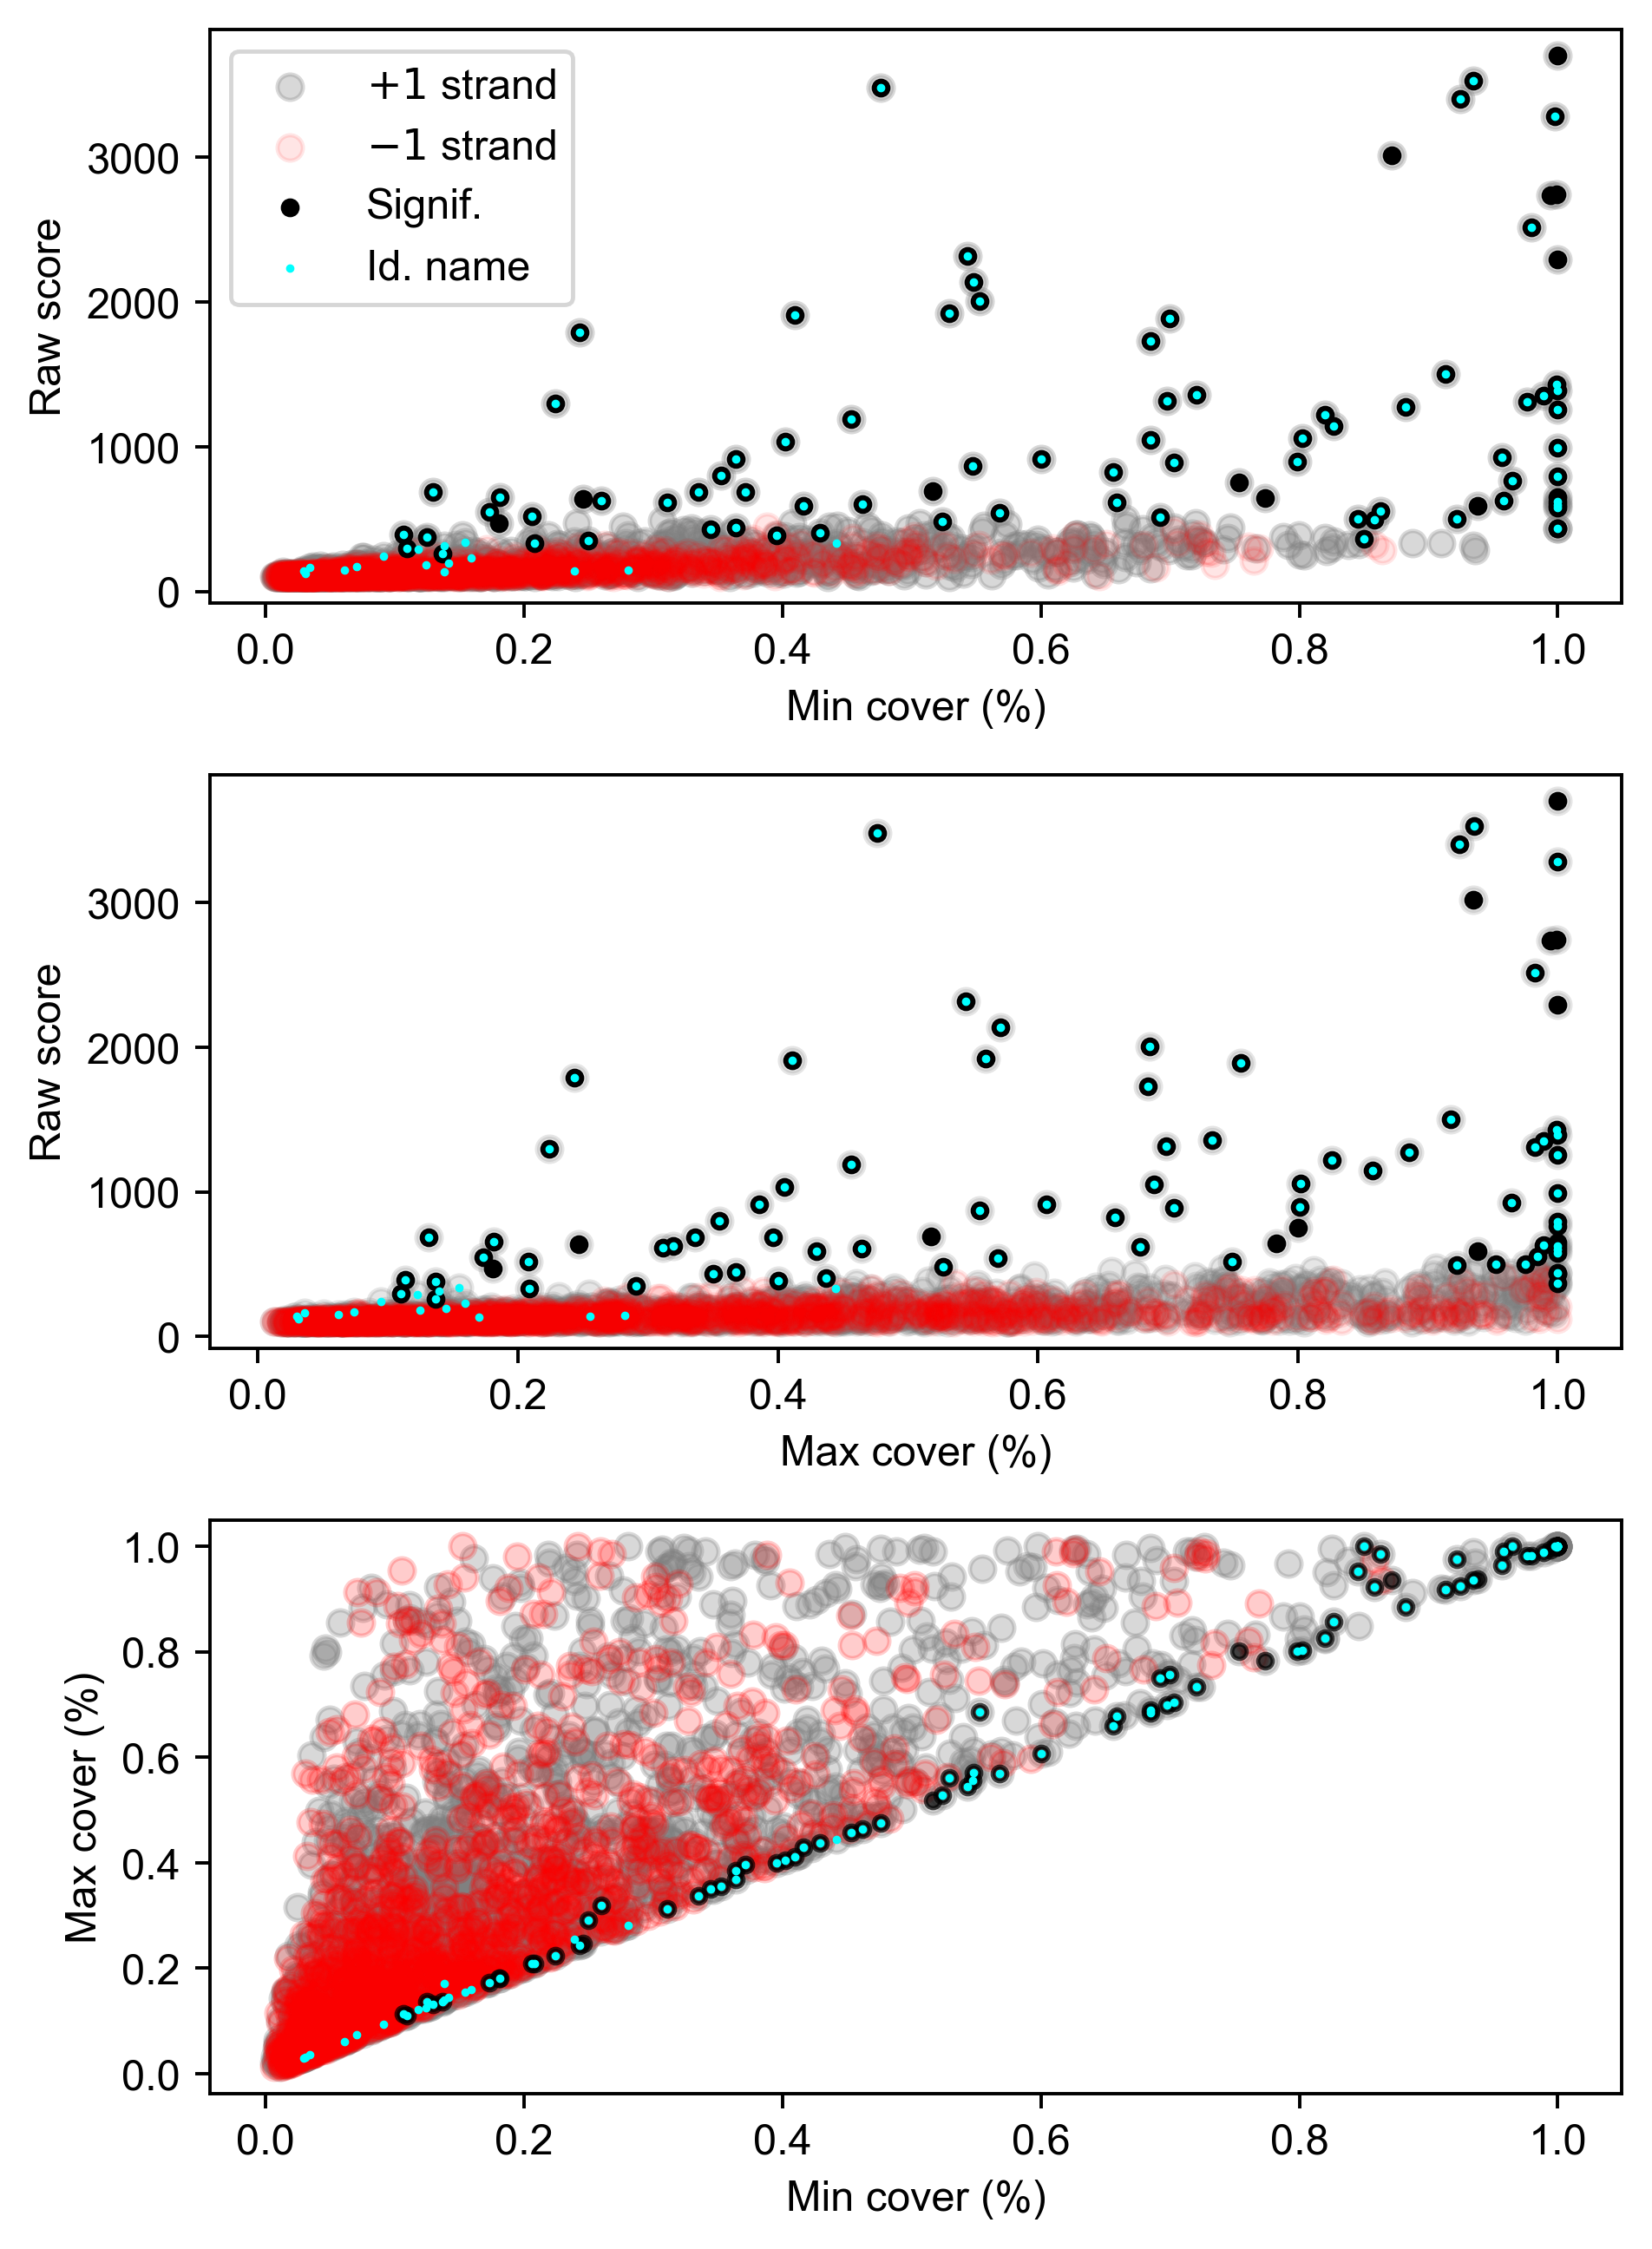

In [1239]:
fig, ax_ = plt.subplots(3, 1, figsize = (6,9), dpi = 350)


ax = ax_[0]
ax.scatter(local_[local_["strand"]==1]["min_cover_percent"], 
           local_[local_["strand"]==1]["raw_score"], 
           alpha = 0.3, color = "grey")
ax.scatter(local_[local_["strand"]==-1]["min_cover_percent"], 
           local_[local_["strand"]==-1]["raw_score"], 
           alpha = 0.1, color = "red")

ax.scatter(chosen["min_cover_percent"], 
           chosen["raw_score"], marker = "o", color = "black", s = 12)

ax.scatter(local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["min_cover_percent"], 
           local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["raw_score"], marker = "o", color = "cyan", s = 1)

ax.set_xlabel("Min cover (%)")
ax.set_ylabel("Raw score")
ax.legend([r"$+1$ strand", r"$-1$ strand", "Signif.", "Id. name"])

ax = ax_[1]
ax.scatter(local_[local_["strand"]==1]["max_cover_percent"], 
           local_[local_["strand"]==1]["raw_score"], 
           alpha = 0.2, color = "grey")
ax.scatter(local_[local_["strand"]==-1]["max_cover_percent"], 
           local_[local_["strand"]==-1]["raw_score"], 
           alpha = 0.1, color = "red")

ax.scatter(chosen["max_cover_percent"], 
           chosen["raw_score"], marker = "o", color = "black", s = 12)

ax.scatter(local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["max_cover_percent"], 
           local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["raw_score"], marker = "o", color = "cyan", s = 1)

ax.set_xlabel("Max cover (%)")
ax.set_ylabel("Raw score")

ax = ax_[2]
ax.scatter((local_[local_["strand"]==1]["min_cover_percent"]), 
           (local_[local_["strand"]==1]["max_cover_percent"]), 
           alpha = 0.3, color = "grey")
ax.scatter((local_[local_["strand"]==-1]["min_cover_percent"]), 
           (local_[local_["strand"]==-1]["max_cover_percent"]), 
           alpha = 0.2, color = "red")

ax.scatter((chosen["min_cover_percent"]), 
           (chosen["max_cover_percent"]), marker = "o", s = 12, color = "black", alpha = 0.7)

ax.scatter(local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["min_cover_percent"], 
           local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["max_cover_percent"], marker = "o", color = "cyan", s = 1)


ax.set_xlabel("Min cover (%)")
ax.set_ylabel("Max cover (%)");


fig.subplots_adjust(hspace = 0.3)
fig.savefig("cover_v_raw_supp.png")


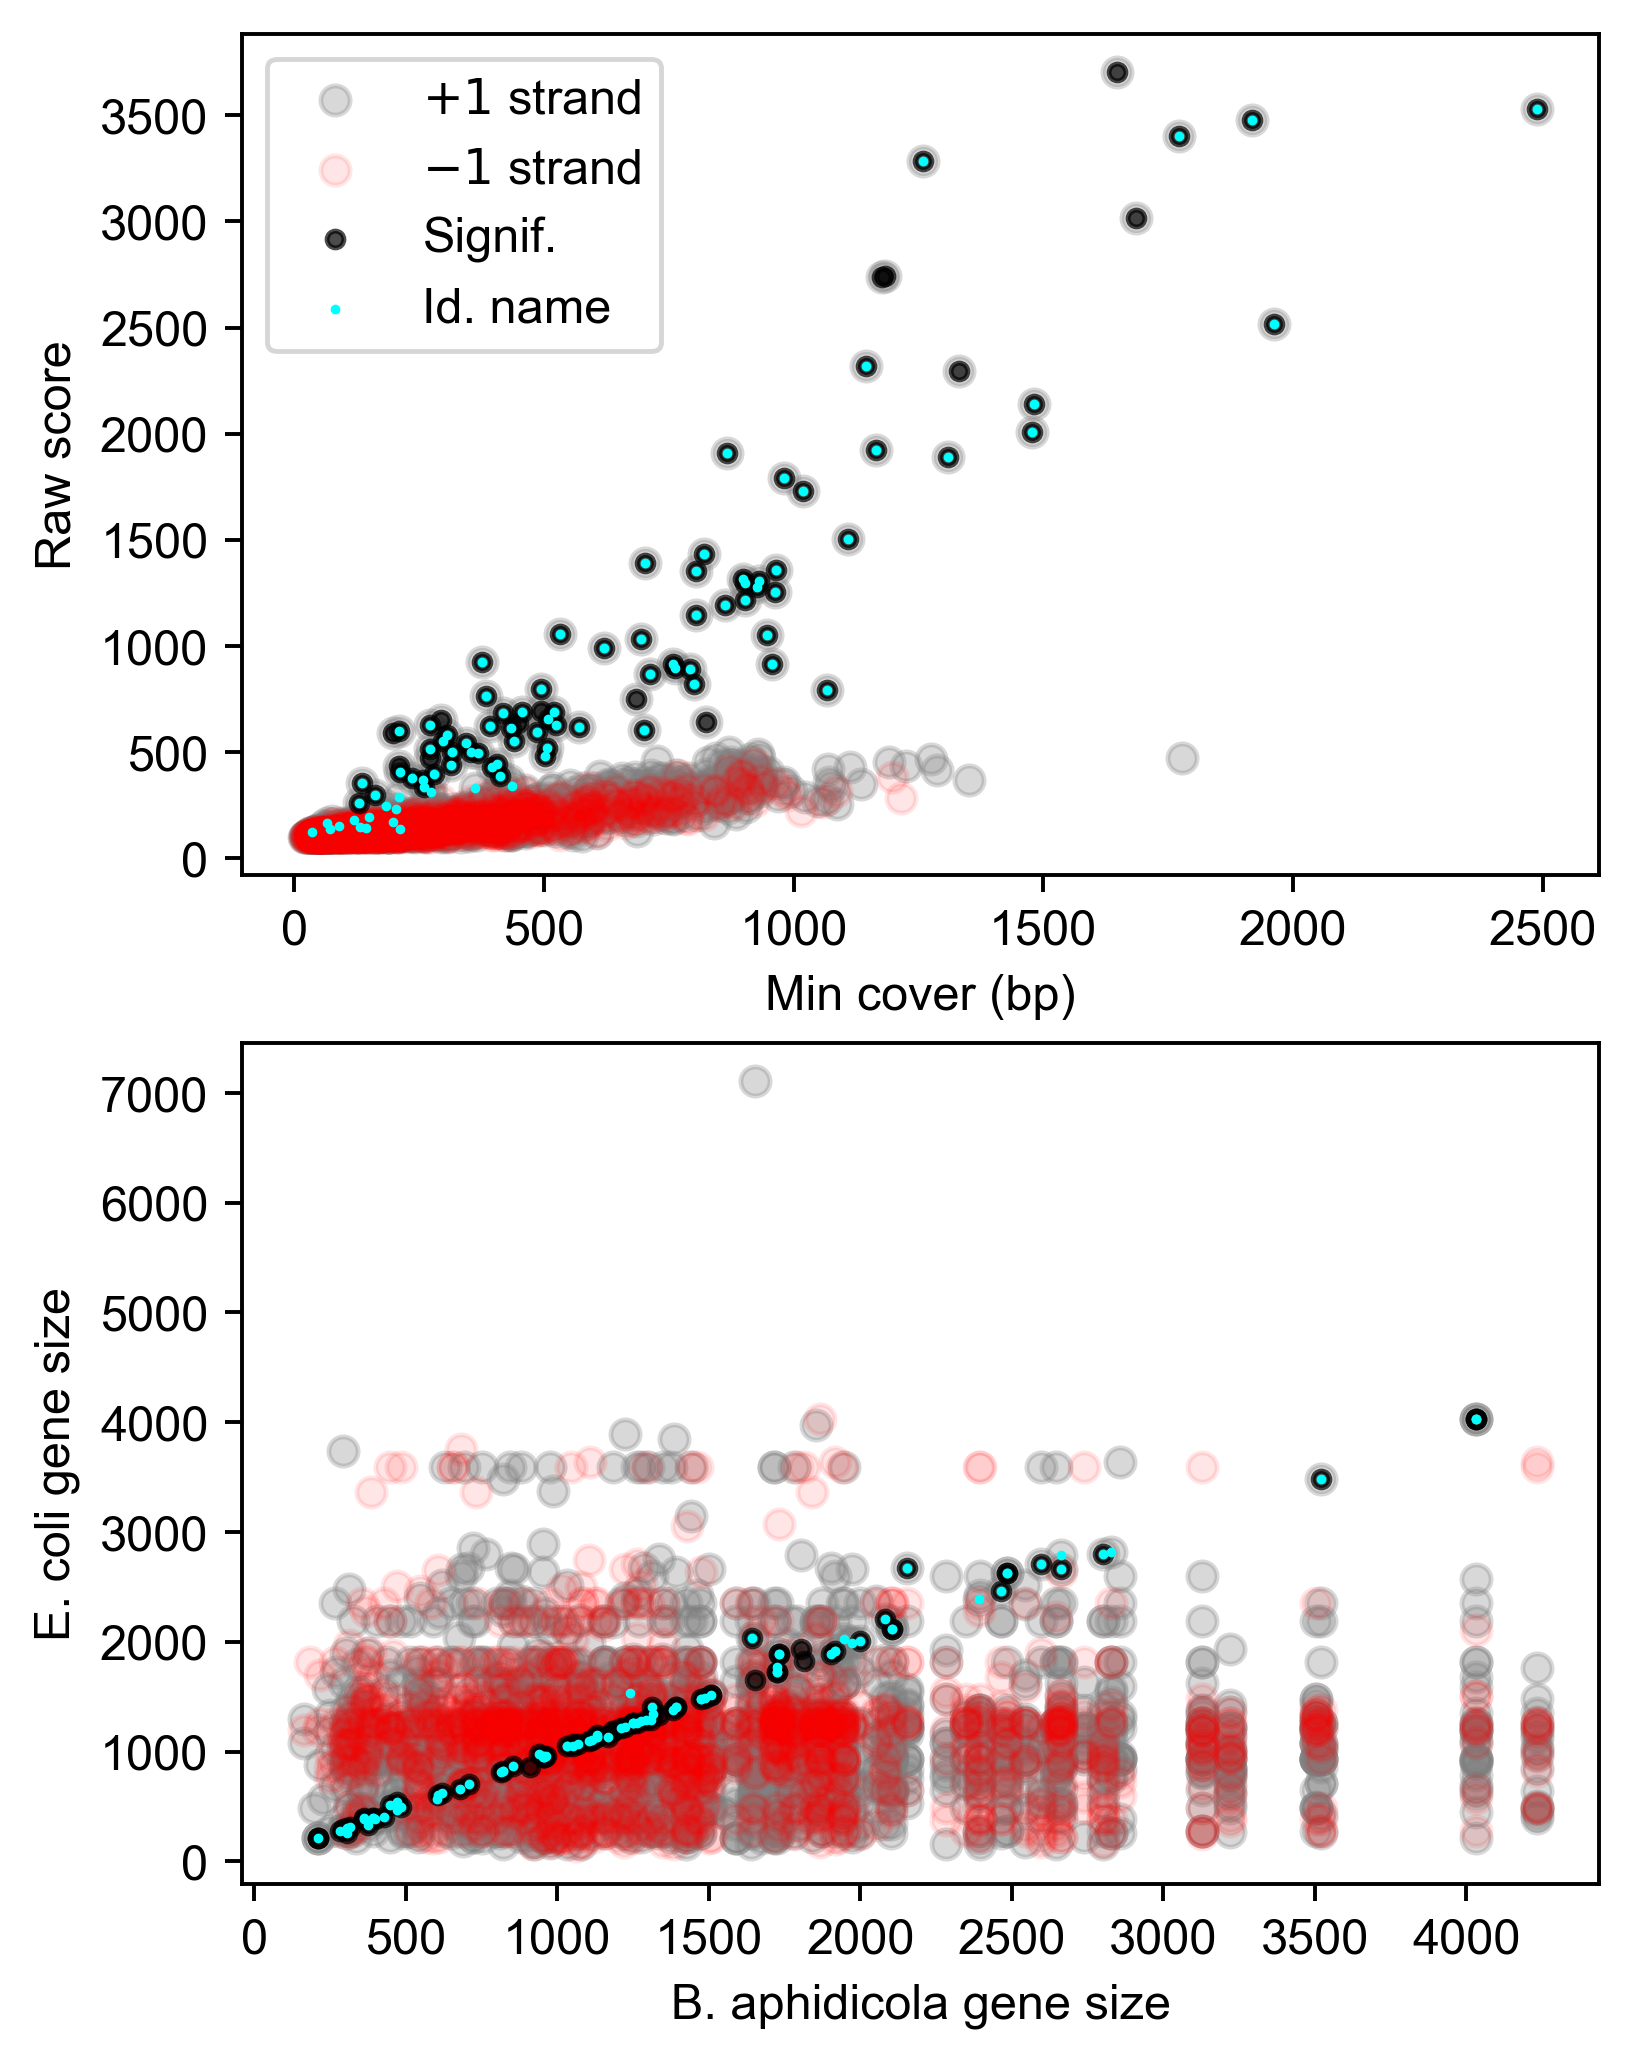

In [1240]:
fig, ax_ = plt.subplots(2, 1, figsize = (5,7), dpi = 350)



ax = ax_[0]
ax.scatter((local_[local_["strand"]==1]["min_cover_bp"]), 
           (local_[local_["strand"]==1]["raw_score"]), 
           alpha = 0.3, color = "grey")
ax.scatter((local_[local_["strand"]==-1]["min_cover_bp"]), 
           (local_[local_["strand"]==-1]["raw_score"]), 
           alpha = 0.1, color = "red")

ax.scatter((chosen["min_cover_bp"]), 
           (chosen["raw_score"]), marker = "o", s = 12, color = "black", alpha = 0.7)
ax.scatter(local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["min_cover_bp"], 
           local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["raw_score"], marker = "o", color = "cyan", s = 1)



ax.set_xlabel("Min cover (bp)")
ax.set_ylabel("Raw score")
ax.legend([r"$+1$ strand", r"$-1$ strand", "Signif.", "Id. name"]);


ax = ax_[1]
ax.scatter((local_[local_["strand"]==1]["length_ba"]), 
           (local_[local_["strand"]==1]["length_ec"]), 
           alpha = 0.3, color = "grey")
ax.scatter((local_[local_["strand"]==-1]["length_ba"]), 
           (local_[local_["strand"]==-1]["length_ec"]), 
           alpha = 0.1, color = "red")

ax.scatter((chosen["length_ba"]), 
           (chosen["length_ec"]), marker = "o", s = 12, color = "black", alpha = 0.7)

ax.scatter(local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["length_ba"], 
           local_[local_["gene_symbol_ba"]==local_["Ec_gene"]]["length_ec"], marker = "o", color = "cyan", s = 1)


ax.set_xlabel("B. aphidicola gene size")
ax.set_ylabel("E. coli gene size");

fig.savefig("cover_v_raw.png")


In [1241]:
local_

Ba_gene  Ba_start  Ba_end Ec_gene  Ec_start  Ec_end  strand  raw_score  \
0     ABJ90603      1619    2132    thrA      1610    2117       1        520   
1     ABJ90601       265    1167    thrC       262    1161       1       1316   
2     ABJ90535       238     732    talB       241     735       1        692   
3     ABJ90573         0    1772    dnaK         0    1772       1       3401   
4     ABJ90573      1842    1910    dnaK      1851    1917       1        167   
...        ...       ...     ...     ...       ...     ...     ...        ...   
3649  ABJ90725      1585    1650    idnK       214     279       1        100   
3650  ABJ90778       250     363    uxuR       428     533       1        126   
3651  ABJ90775       770     812    fhuF       540     582       1        120   
3652  ABJ90768       672     713    yjjU       286     246      -1        104   
3653  ABJ90714       230     254    yjtD       663     687       1        102   

     fa_name_ba  chr_start_ba  ...  n_aligns_all_ec  n_aligns_chosen_ec  \
0      ABJ90603        143574  ...                2                   1   
1      ABJ90601        141328  ...                1                   1   
2      ABJ90535         62504  ...                2                   1   
3      ABJ90573        108818  ...                2                   1   
4      ABJ90573        108818  ...                2                   1   
...         ...           ...  ...              ...                 ...   
3649   ABJ90725        292106  ...                7                   0   
3650   ABJ90778        360678  ...                2                   0   
3651   ABJ90775        358687  ...                1                   0   
3652   ABJ90768        354529  ...                3                   0   
3653   ABJ90714        281409  ...                2                   0   

     at_density_ec ec_align_length ba_align_length min_cover_bp  \
0         0.469346             507             513          507   
1         0.471639             899             902          899   
2         0.480084             494             494          494   
3         0.488785            1772            1772         1772   
4         0.488785              66              68           66   
...            ...             ...             ...          ...   
3649      0.565603              65              65           65   
3650      0.463824             105             113          105   
3651      0.468948              42              42           42   
3652      0.460894              40              41           40   
3653      0.502183              24              24           24   

     ec_align_length_percent  ba_align_length_percent  min_cover_percent  \
0                   0.205847                 0.208283           0.205847   
1                   0.698524                 0.697602           0.697602   
2                   0.517820                 0.516196           0.516196   
3                   0.924361                 0.924361           0.924361   
4                   0.034429                 0.035472           0.034429   
...                      ...                      ...                ...   
3649                0.115248                 0.039394           0.039394   
3650                0.135659                 0.228283           0.135659   
3651                0.053232                 0.032407           0.032407   
3652                0.037244                 0.042842           0.037244   
3653                0.034934                 0.089888           0.034934   

      max_cover_percent  
0              0.208283  
1              0.698524  
2              0.517820  
3              0.924361  
4              0.035472  
...                 ...  
3649           0.115248  
3650           0.228283  
3651           0.053232  
3652           0.042842  
3653           0.089888  

[3654 rows x 38 columns]

In [863]:
chosen[["gene_symbol_ba", 
        "fa_name_ec", 
        "description_ba", 
        "description_ec", 
        "length_ba", 
        "length_ec", 
        "min_cover_bp", 
        "min_cover_percent", 
        "raw_score"]].to_csv("chosen.csv", 
                             float_format='%.3f')



In [974]:
len(set(local_.drop_duplicates(subset=["Ba_gene", "Ec_gene"])["Ec_gene"]))

759

In [1242]:
# looking at repetitions

unique_all_ba = collections.Counter(local_["Ba_gene"])
unique_all_ec = collections.Counter(local_["Ec_gene"])

unique_chosen_ba = collections.Counter(chosen["Ba_gene"])
unique_chosen_ec = collections.Counter(chosen["Ec_gene"])

In [1243]:
baphidicola.loc[:, "n_aligns_all"] = [unique_all_ba.get(x, 0) for x in baphidicola["fa_name"]]
ecoli.loc[:, "n_aligns_all"] = [unique_all_ec.get(x, 0) for x in ecoli["fa_name"]]

chosen.loc[:, "n_aligns_all_ba"] = [unique_all_ba.get(x, 0) for x in chosen["Ba_gene"]]
chosen.loc[:, "n_aligns_all_ec"] = [unique_all_ec.get(x, 0) for x in chosen["Ec_gene"]]

baphidicola.loc[:, "n_aligns_chosen"] = [unique_chosen_ba.get(x, 0) for x in baphidicola["fa_name"]]
ecoli.loc[:, "n_aligns_chosen"] = [unique_chosen_ec.get(x, 0) for x in ecoli["fa_name"]]

/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


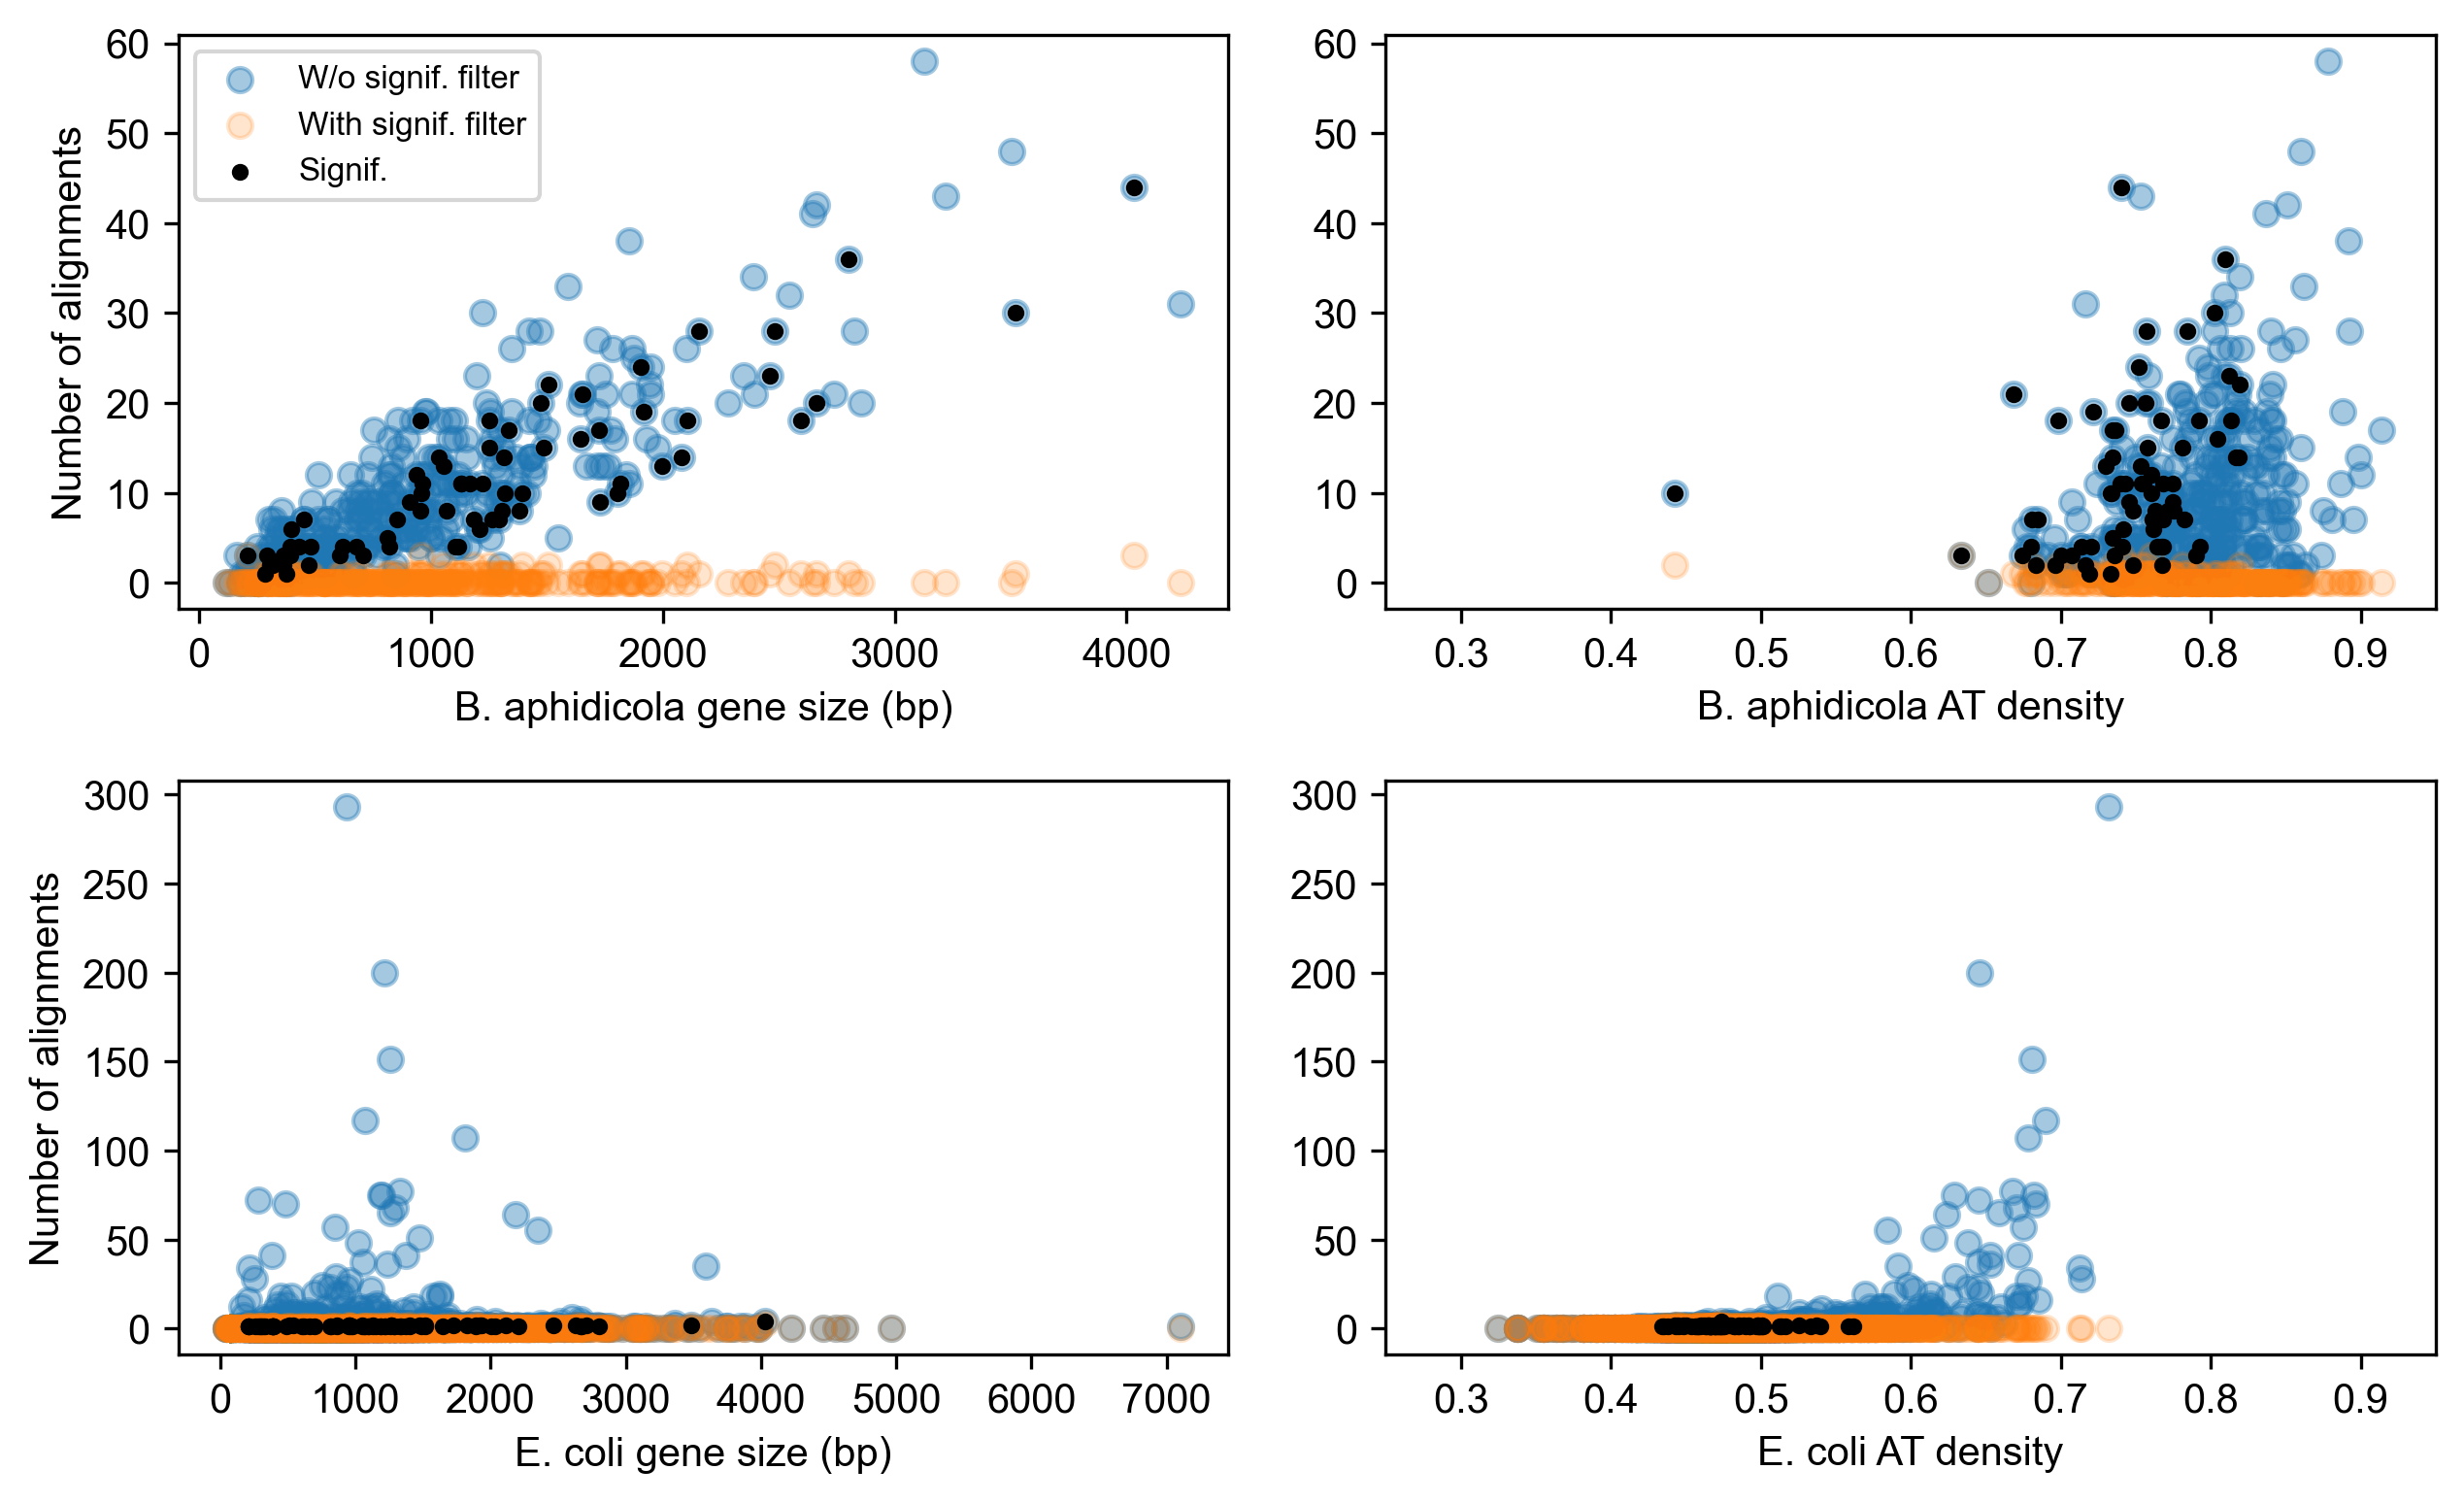

In [1259]:
fig, ax_ = plt.subplots(2,2, figsize = (10,6))

ax = ax_[0, 0]
ax.scatter(baphidicola["length"], baphidicola["n_aligns_all"], alpha = 0.4)
ax.scatter(baphidicola["length"], baphidicola["n_aligns_chosen"], alpha = 0.2)
ax.scatter(baphidicola[baphidicola["n_aligns_chosen"]>0]["length"], 
           baphidicola[baphidicola["n_aligns_chosen"]>0]["n_aligns_all"], color = "black", s = 10)

ax.set_xlabel("B. aphidicola gene size (bp)")
ax.set_ylabel("Number of alignments")
ax.legend(["W/o signif. filter", "With signif. filter", "Signif."], prop={'size': 8})


ax = ax_[1, 0]
ax.scatter(ecoli["length"], ecoli["n_aligns_all"], alpha = 0.4)
ax.scatter(ecoli["length"], ecoli["n_aligns_chosen"], alpha = 0.2)
ax.scatter(ecoli[ecoli["n_aligns_chosen"]>0]["length"], 
           ecoli[ecoli["n_aligns_chosen"]>0]["n_aligns_all"], color = "black", s = 10)

ax.set_xlabel("E. coli gene size (bp)")
ax.set_ylabel("Number of alignments")

ax = ax_[0, 1]
ax.scatter(baphidicola["at_density"], baphidicola["n_aligns_all"], alpha = 0.4)
ax.scatter(baphidicola["at_density"], baphidicola["n_aligns_chosen"], alpha = 0.2)
ax.set_xlim([0.25, 0.95])
ax.scatter(baphidicola[baphidicola["n_aligns_chosen"]>0]["at_density"], 
           baphidicola[baphidicola["n_aligns_chosen"]>0]["n_aligns_all"], color = "black", s = 10)
ax.set_xlabel("B. aphidicola AT density")

ax = ax_[1, 1]
ax.scatter(ecoli["at_density"], ecoli["n_aligns_all"], alpha = 0.4)
ax.scatter(ecoli["at_density"], ecoli["n_aligns_chosen"], alpha = 0.2)
ax.scatter(ecoli[ecoli["n_aligns_chosen"]>0]["at_density"], 
           ecoli[ecoli["n_aligns_chosen"]>0]["n_aligns_all"], color = "black", s = 10)
ax.set_xlim([0.25, 0.95])
ax.set_xlabel("E. coli AT density")


fig.subplots_adjust(hspace = 0.3, wspace = 0.15)

fig.savefig("sizeValigns.png")

In [946]:
go_all = pd.read_csv("analysis (3).txt", delimiter = "\t")
go_all.columns = ["process", "ec_count", "ba_count", "expected", "fold_sign", "fold_change", "p_val", "fdr"]
go_all = go_all.replace(" < 0.01", 0)
go_all = go_all.astype({"fold_change":"float64"})

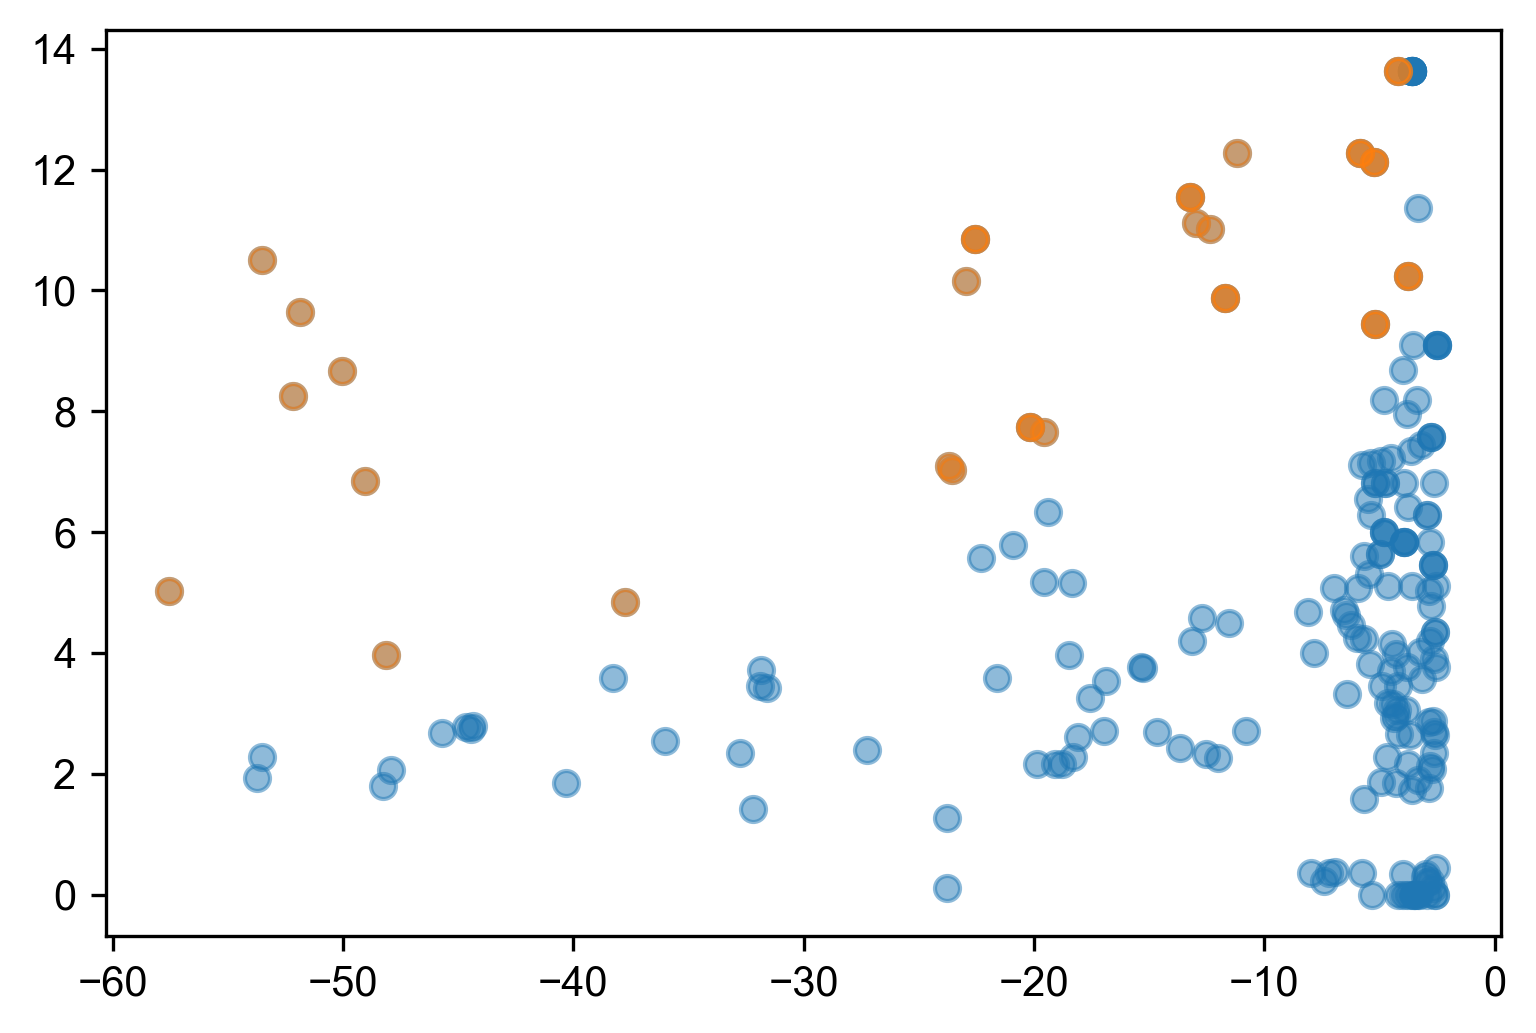

In [962]:
plt.scatter(np.log10(go_all["p_val"]), go_all["fold_change"], alpha = 0.5)
# chosen_go = go_all[go_all["fold_change"]> 10 + 7/50*np.log10(go_all["p_val"])]
plt.scatter(np.log10(chosen_go["p_val"]), chosen_go["fold_change"], alpha = 0.5)


In [961]:
chosen_go = chosen_go[chosen_go["p_val"]< 0.05/208]

In [964]:
chosen_go.to_csv("chosen_go.csv")


(array([13.,  4.,  3.,  3.,  1.,  0.,  0.,  2.,  1.,  0.,  2.,  0.,  1.,
         9., 14.,  6.,  0.,  5.,  2.,  2.,  0.,  1.,  1.,  2.,  1.,  3.,
         0.,  1.,  4.,  8.,  0.,  6.,  2.,  1.,  1.,  1.,  0.,  2.,  0.,
         5.,  0.,  1.,  2.,  1.,  0.,  4.,  5.,  5., 11.,  6.,  2.,  1.,
         0.,  0.,  1.,  2.,  0.,  0.,  2.,  1.,  1.,  1.,  0.,  2.,  0.,
         0.,  0.,  1.,  4.,  2.,  3.,  2.,  3.,  5.,  0.,  0.,  0.,  5.,
         2.,  0.,  2.,  4.,  2.,  4.,  2.,  1.,  0.,  0.,  0.,  0.,  2.,
         2.,  0.,  3.,  4.,  8., 16.,  2.,  6., 53.]),
 array([  1.  ,  10.35,  19.7 ,  29.05,  38.4 ,  47.75,  57.1 ,  66.45,
         75.8 ,  85.15,  94.5 , 103.85, 113.2 , 122.55, 131.9 , 141.25,
        150.6 , 159.95, 169.3 , 178.65, 188.  , 197.35, 206.7 , 216.05,
        225.4 , 234.75, 244.1 , 253.45, 262.8 , 272.15, 281.5 , 290.85,
        300.2 , 309.55, 318.9 , 328.25, 337.6 , 346.95, 356.3 , 365.65,
        375.  , 384.35, 393.7 , 403.05, 412.4 , 421.75, 431.1 , 440.45,
  

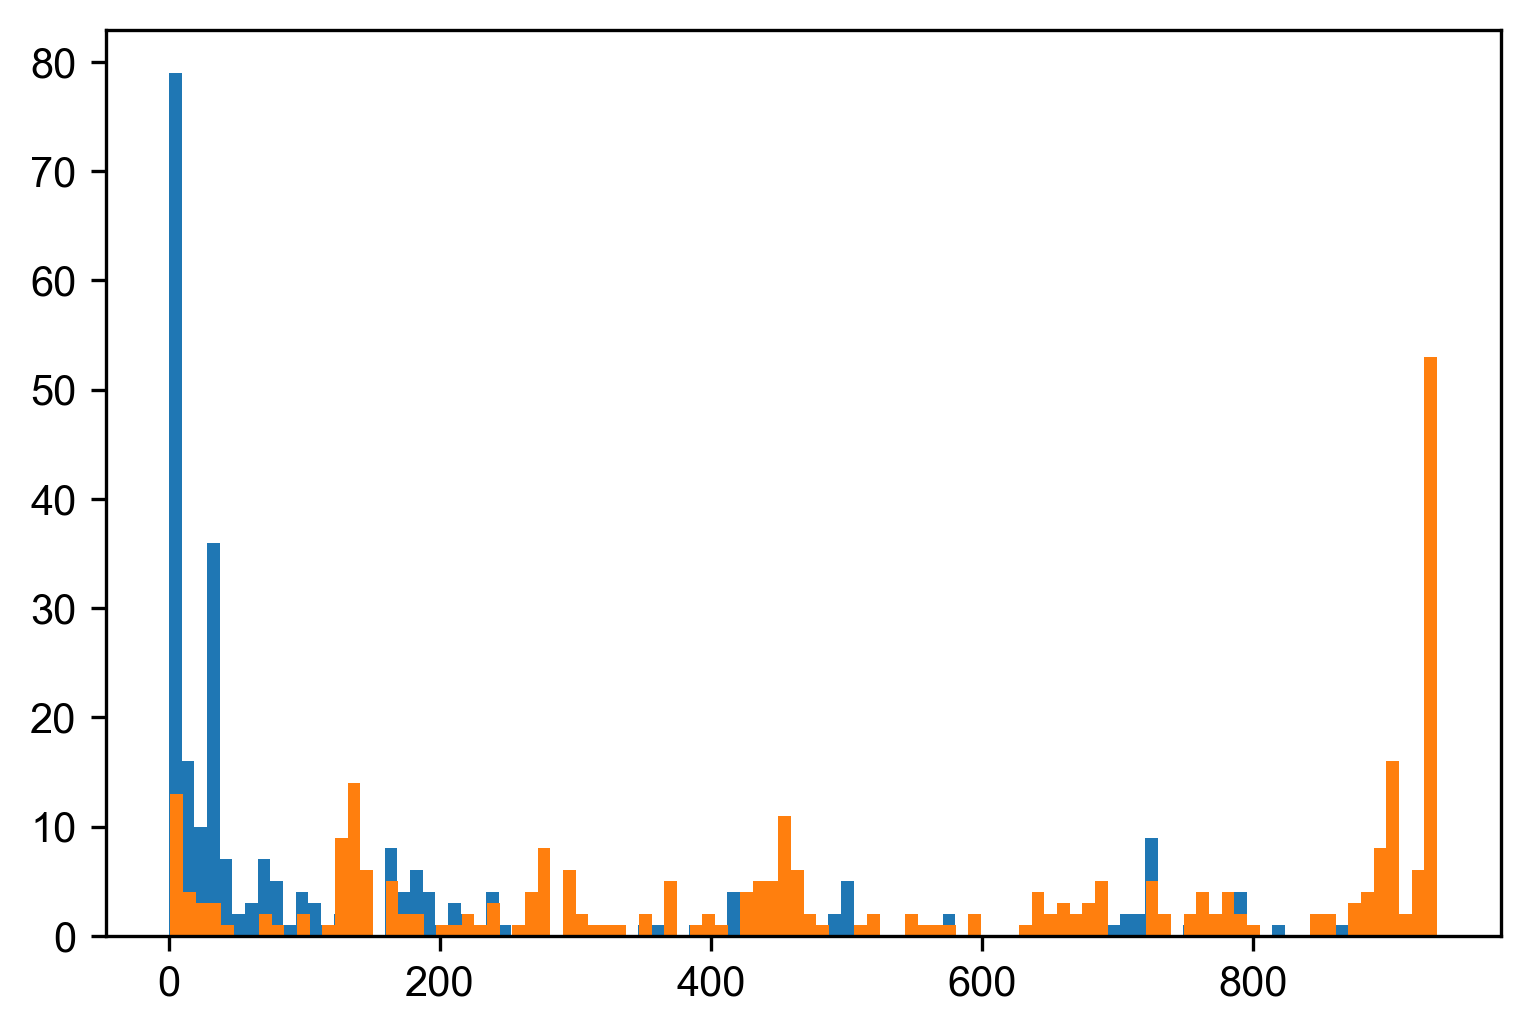

In [990]:
plt.hist(local_[local_["Ec_gene"]=='rfaS']["Ec_start"], bins = 100)
plt.hist(local_[local_["Ec_gene"]=='rfaS']["Ec_end"], bins = 100)

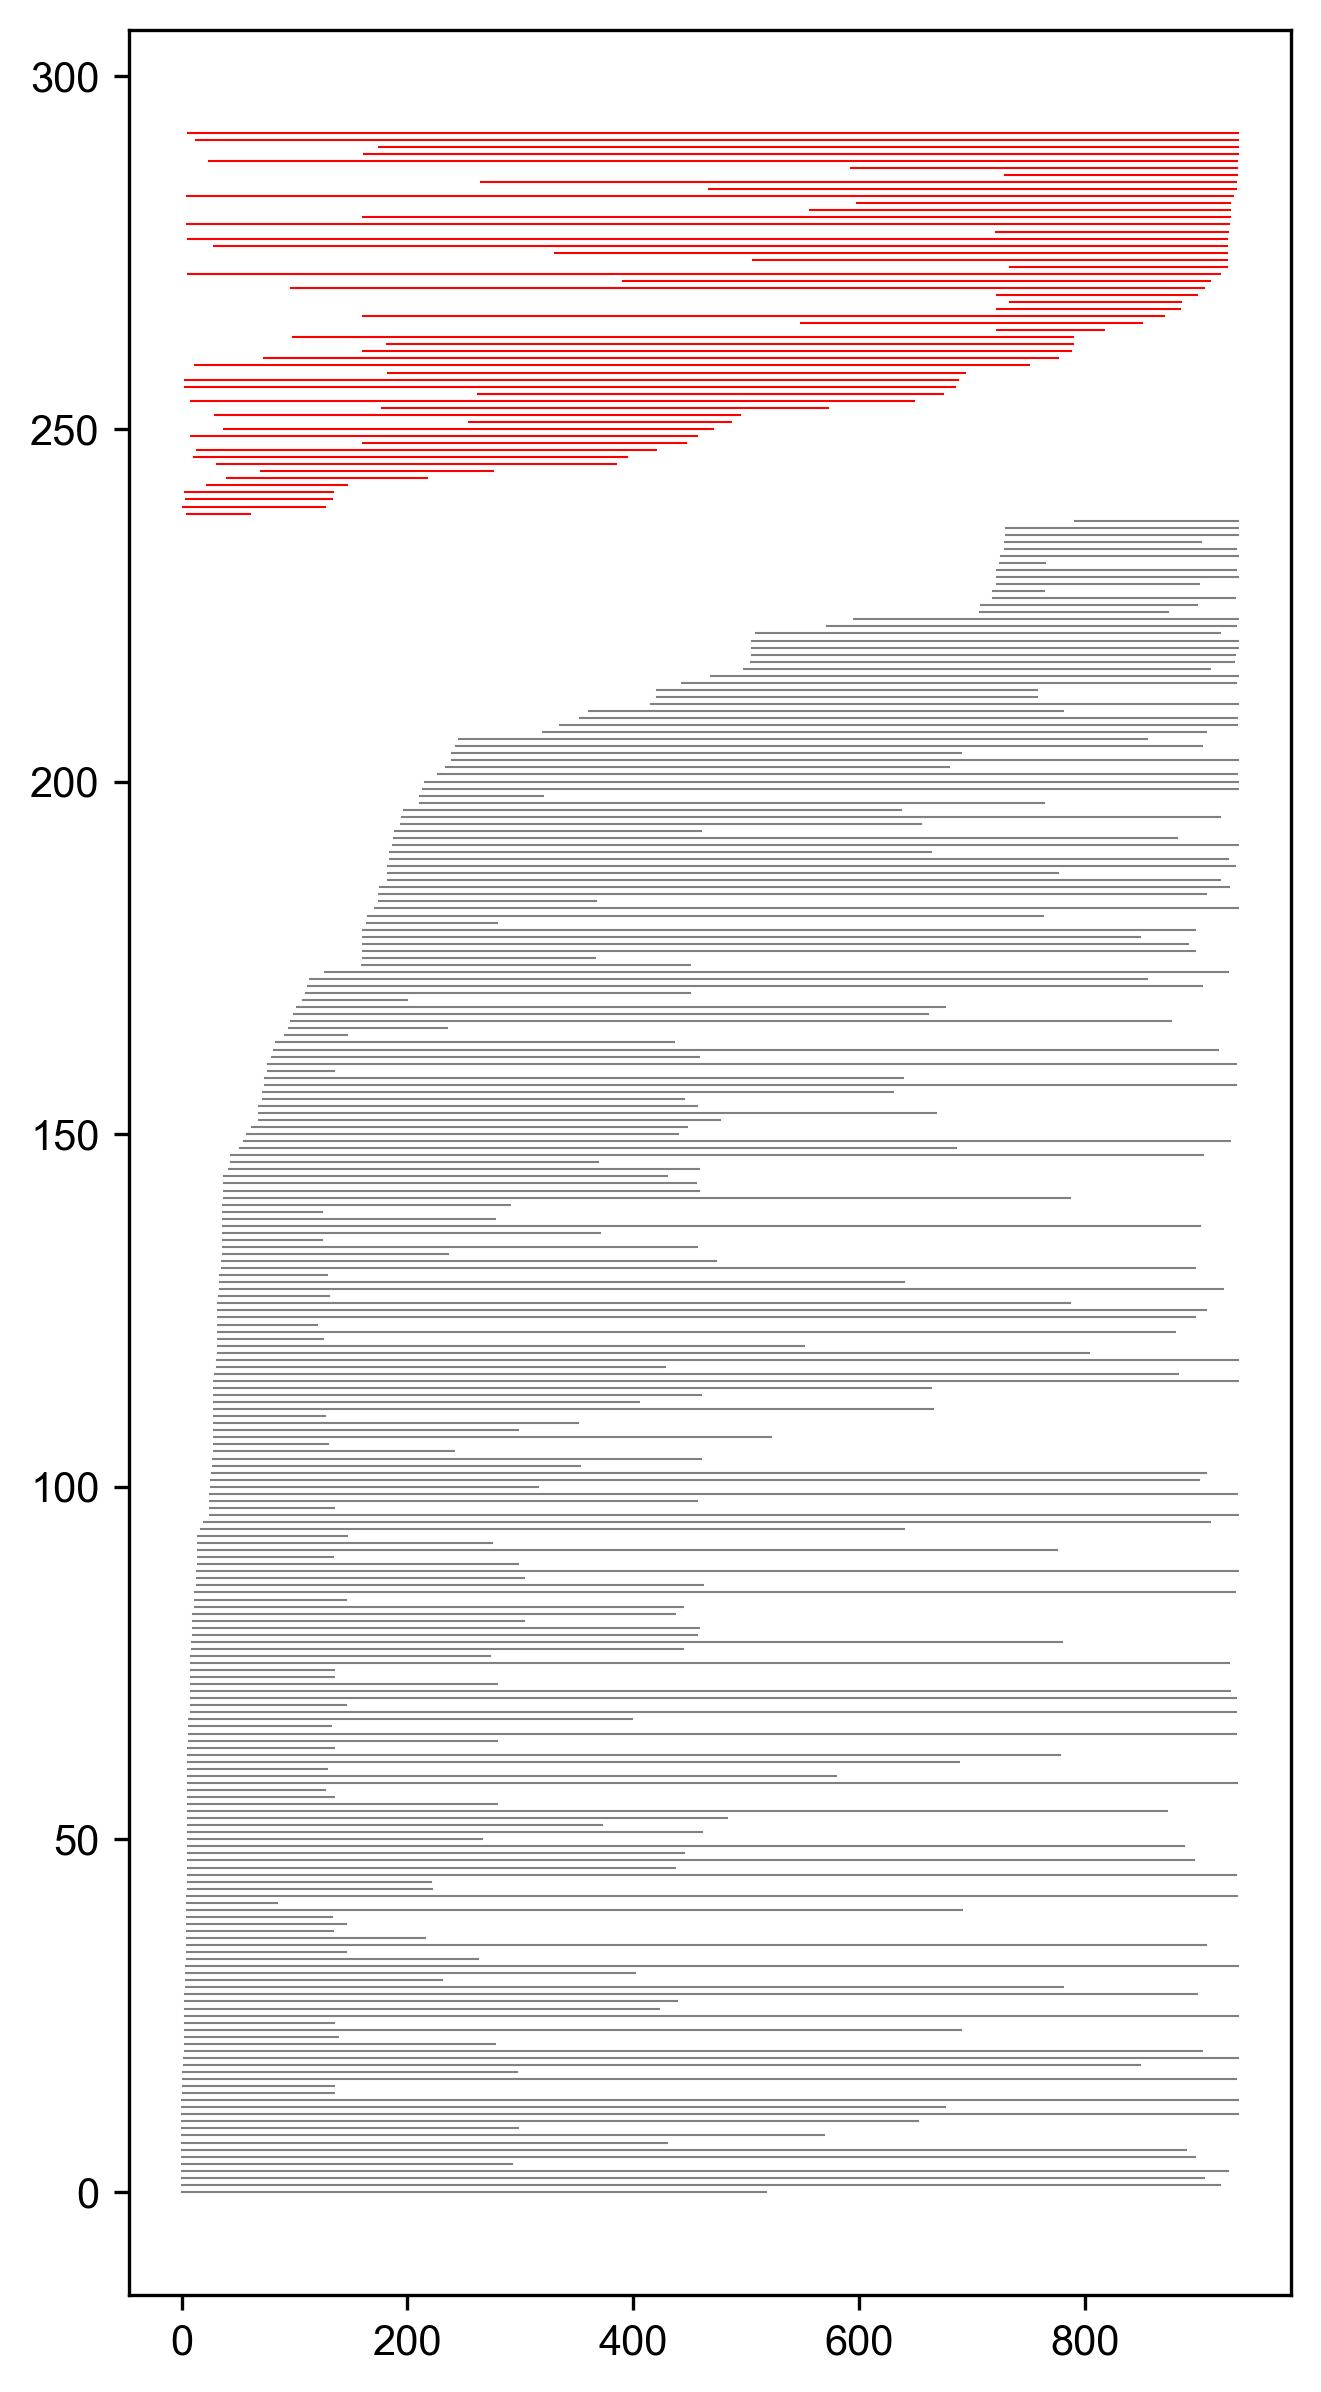

In [1014]:
rfas = local_[local_["Ec_gene"]=='rfaS'].sort_values("Ec_end").sort_values("Ec_start")

fig, ax = plt.subplots(figsize = (5, 10))
y = 0
for idx, start in enumerate(list(rfas[rfas["strand"]==1]["Ec_start"])):    
    plt.plot([start, list(rfas[rfas["strand"]==1]["Ec_end"])[idx]], [y,y], color = "grey", linewidth = 0.5)
    y += 1
for idx, start in enumerate(list(rfas[rfas["strand"]==-1]["Ec_start"])):    
    plt.plot([start, list(rfas[rfas["strand"]==-1]["Ec_end"])[idx]], [y,y], color = "red", linewidth = 0.5)
    y += 1

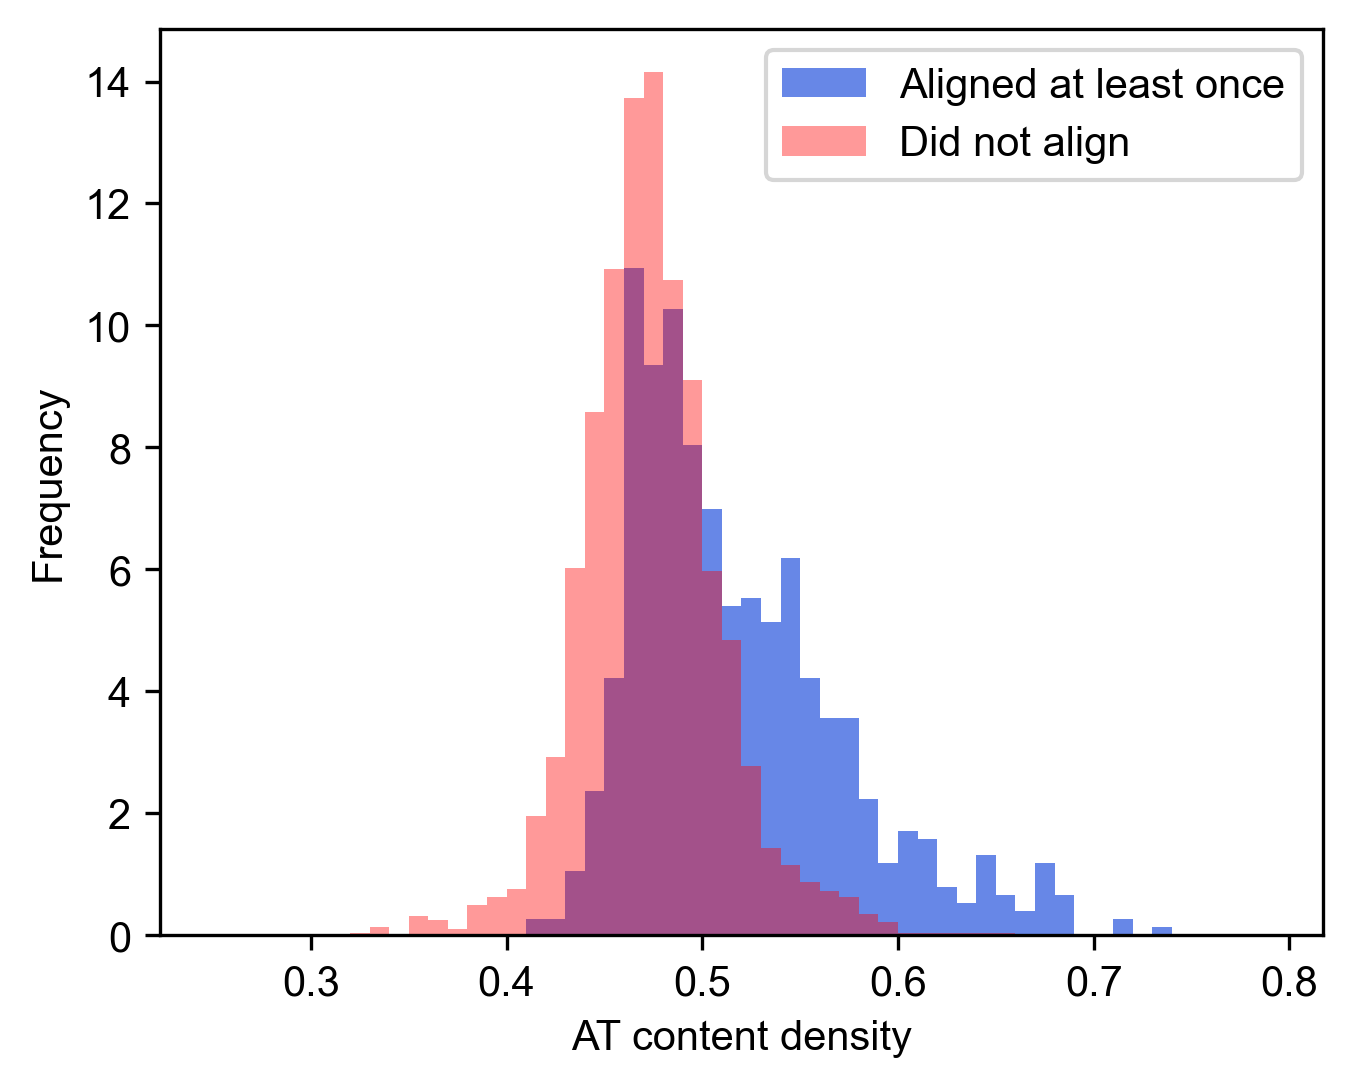

In [1287]:
fig, ax = plt.subplots(figsize = (5,4))

ax.hist(ecoli[ecoli["n_aligns_all"]>=1]["at_density"], density = True, bins = np.arange(0.25, 0.8, 0.01), color = "royalblue", alpha = 0.8)
ax.hist(ecoli[ecoli["n_aligns_all"]==0]["at_density"], alpha = 0.4, density = True, bins = np.arange(0.25, 0.8, 0.01), color = "red")
ax.set_xlabel("AT content density")
ax.set_ylabel("Frequency")
ax.legend(["Aligned at least once", "Did not align"])

fig.savefig("atcontentValign.png")

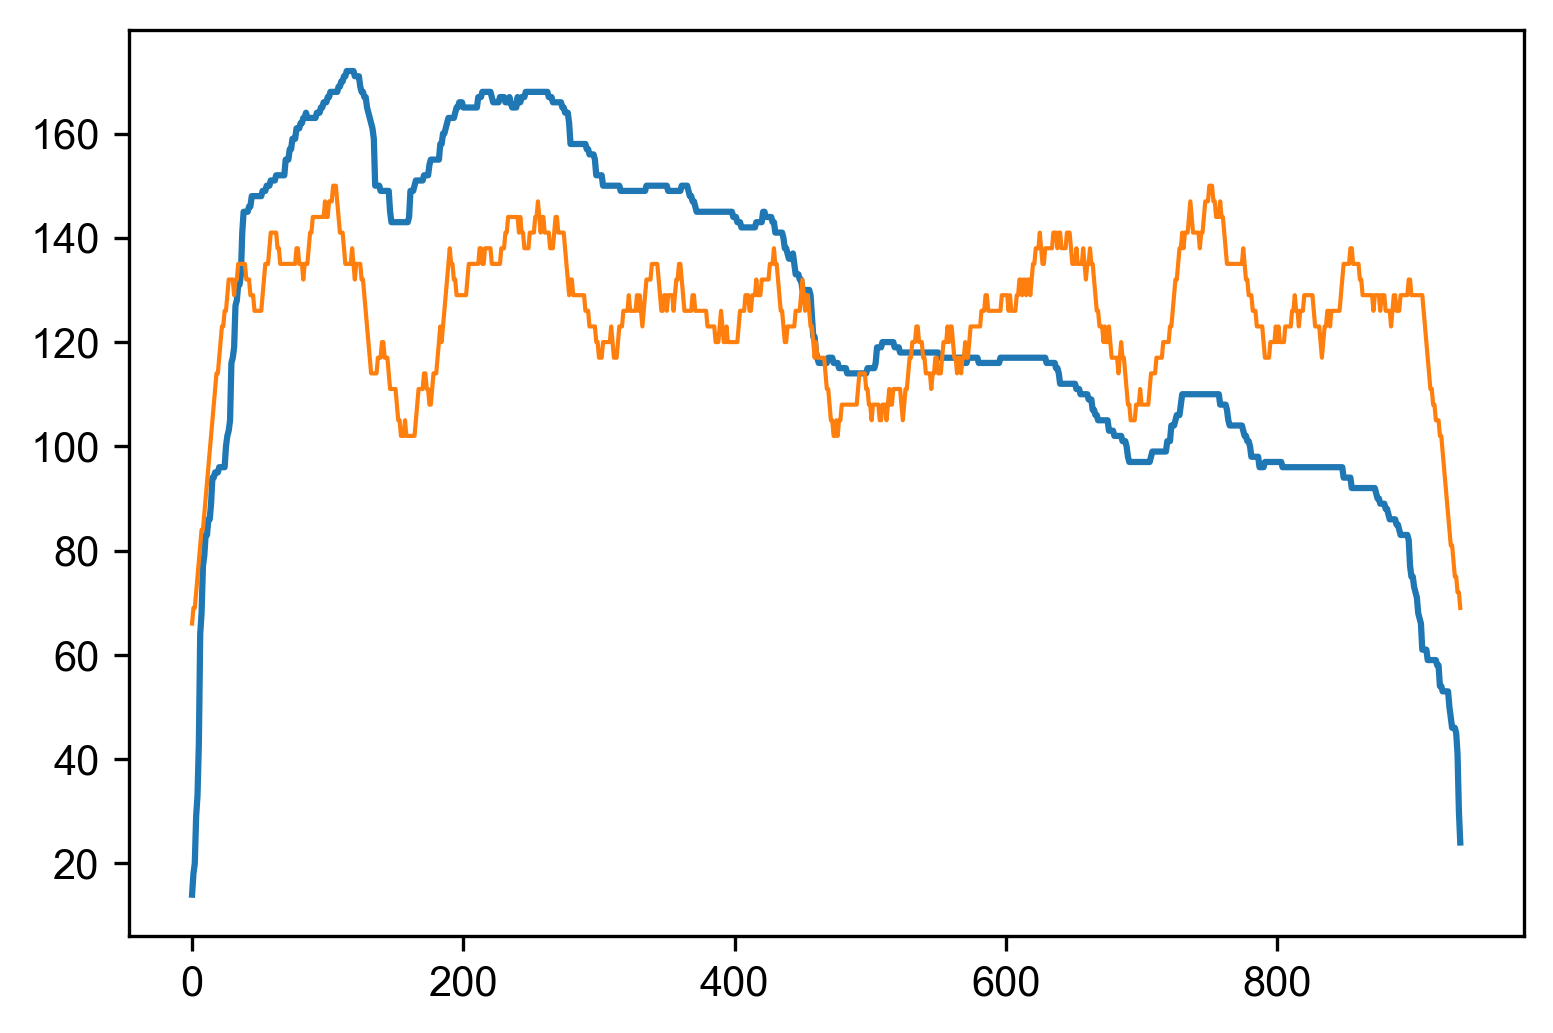

In [1292]:
rfas_seq = "ATGACTATTTATTTTATAAATTGGGTTGCAGATTATGAATTAAAAATGATTCAGTACCTGAAAAAAAAGTACAAGATAAAAAATATAACAACACCAAAAAAATATAACTGGATTAATAAAAAAATATCAAAAATAGGGATGGATAATGCATGGCTGGGGCGATTATTCATCAAGCATTACCTCAATGATATTAAAAAAGATGACATAATTATCATTAATGACAGTGTTGTTAATAAAGGTATCAATAAACAAATATTAAAAAATATTAACTGTCATAAAGTTTTGCTTCTAAGAAATACTGTTGGCGAAGATTTTATTCTTGATAACGCGAATTATTTCGATATTATATATGATTTTGAGCATAGATTTATAGGGAATGAAAAGATCAAGGCAATAGAACAATTTTTTCCTATAGGAATGGATGAAATTAGAAATTATAGTTTATCTGACAAAAATAACAGCCAGCCAATATGTTTTTTCCTTGGTCGTGATAAAGGGCGTCTTCAAATAATTAATGAGTTAGCCGAGAGATTAACAACACTAGGATGTAAGCTAGATTTTAATGTTGTCAAAGATAAGACATCATCTACGACTTCAAAGTATTTGATTGAAAAACAAATATCTTATGAAGAGAATATTAGAAGAACATTAAATGCTAATATAATTGTTGATATAACCAAAGAAAACCAATCTGGCTGGACTCTTCGTATACTTGAGGCACTATTTTTCAATAAAAAATTAATTACTAATAATATAAATGTATTTGGTTCAGAAATCTATAGTGAATCTCGCTTTTTTATAATAGGTCATGATGATTGGGATAAGTTAGAGTATTTTATTAACTCATCTGTTAAACCAATGGATTATGATAGTTTATATAAATTCAGTCCAGATAAAATGATGTCAACGATTGTTTCTGATTTTATAGACAAATAA"


# calculating rfaS coverage

coverage = np.zeros(936)

covstrt = rfas[rfas["strand"]==1][["Ec_start", "Ec_end"]].min(axis = 1).tolist()
covend = rfas[rfas["strand"]==1][["Ec_start", "Ec_end"]].max(axis = 1).tolist()

for s,e in zip(covstrt, covend):
    coverage[s:e] += 1

def ATcount(seq, k):
    kmers = [seq[max(0, i-k//2):min(len(seq),i+k//2)] for i in range(len(seq))]
    counter = []
    for kmer in kmers:
        counter.append(kmer.count('T')+kmer.count('A'))
    return counter

plt.plot(coverage)
for k in [59]:
    at = np.array(ATcount(rfas_seq, k))
    plt.plot(at*3, linewidth = 1)

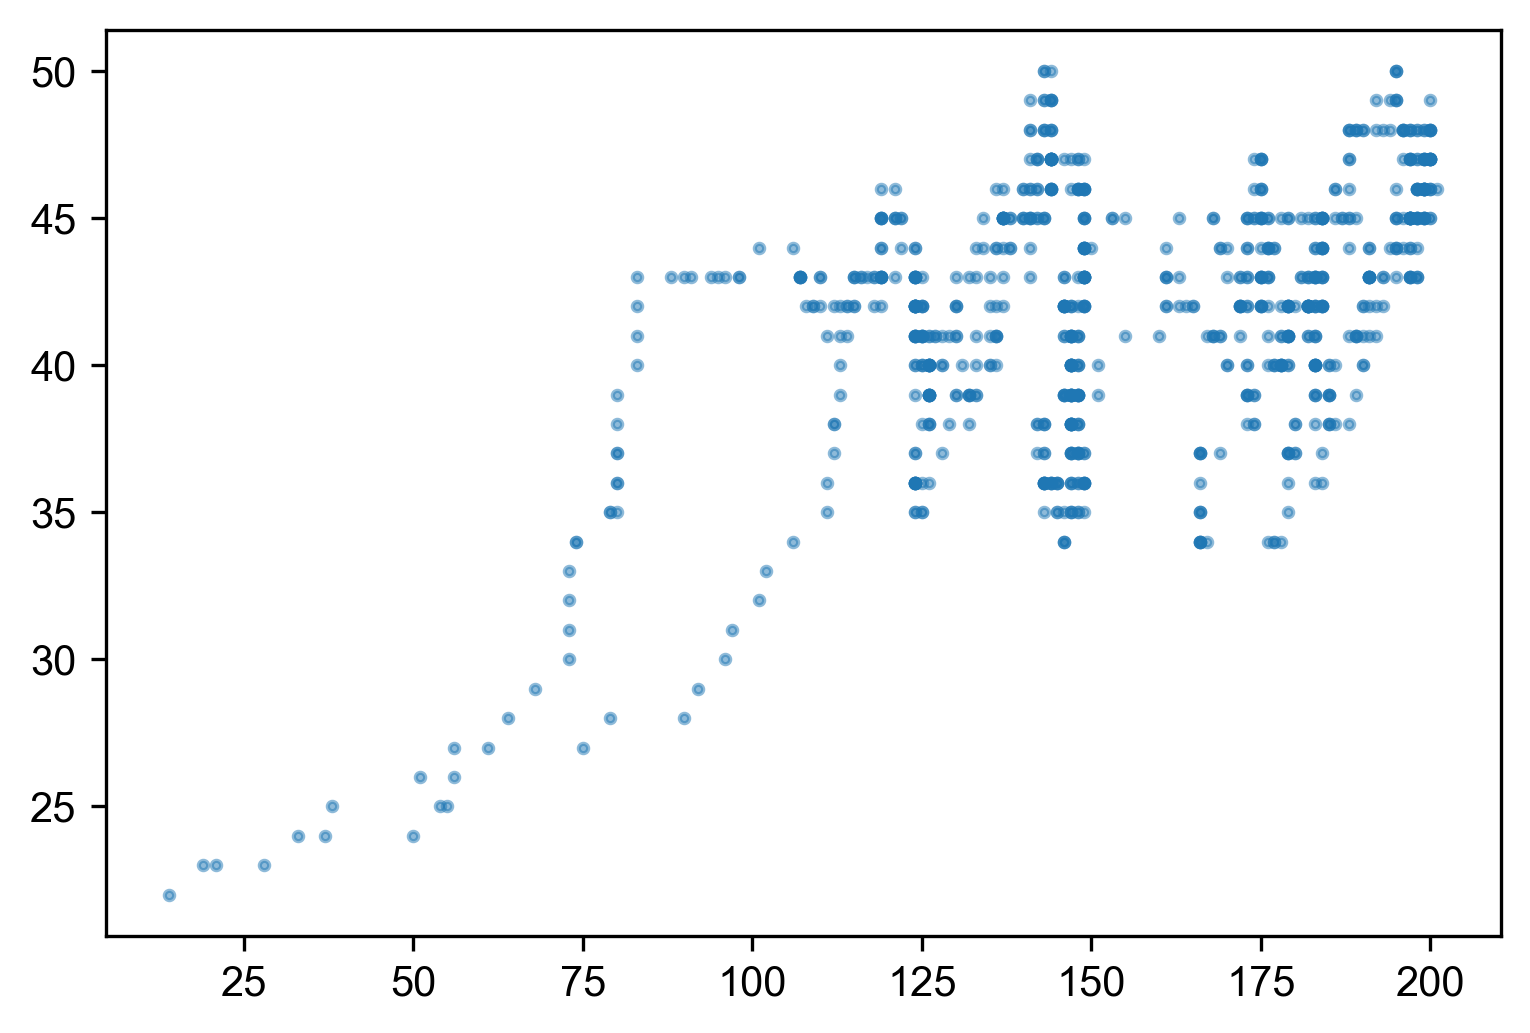

In [1130]:
plt.scatter(coverage, at, alpha = 0.5, s = 5)